## 목차
### 0. 요약
### 1. 전처리(투자자 타케팅 및 분류)
> * 1.1 투자자금 유추
### 2. 데이터 분석
> * 2.1 수익률 분석
> * 2.2 매매회전율 분석
> * 2.3 이탈기간 분석
### 3. 주린이/베테랑 yz/old 구분 투자자 K-means 군집분석
> * 3.1 elbow 적정 군집수 책정
> * 3.2 군집별 특성들 비교 시각화
> * 3.3 군집 분석 및 공통점 도출을 통한 유형화
### 4. 유형 분석
> * 4.1 선호 종목 분석
> * 4.2 손익 종목 분석
### 5. 결론

### 세팅

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mlxtend
import matplotlib

In [2]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
pd.options.display.float_format = '{:.2f}'.format
matplotlib.rcParams['axes.unicode_minus'] = False

In [3]:
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

### 사용함 함수들

In [4]:
# 거래내역을 넣으면 매수 경우만 취급해서 한번이라도 해당 종목을 샀으면 1로 쳐서 표시
def plot_buy_iem(data, title):
    y = data[(data['매매구분코드'] == 0) | (data['매매구분코드'] == 2)] # 매수 거래량만 따로 추출
    y = y.drop_duplicates(subset = ['고객번호', '종목 한글명'], keep = 'first') # 같은 종목 내 여러번 매수한 기록 삭제 하나만 남김
    y_ct = y.groupby(['고객번호', '종목 한글명'], as_index = False)['종목코드'].count() # 고객별로 매수한 종목이 다 1로 됨

    y_ct_sc = y_ct.pivot(index = '고객번호', columns = '종목 한글명')['종목코드'] # 고객 / 종목 테이블로 매수한 경우 1 아닌 경우 0
    y_ct_sc = y_ct_sc.fillna(0)

    fig, ax = plt.subplots(figsize = (14,6))
    data = y_ct_sc.sum().sort_values(ascending = False)[:50]

    sns.barplot(x = data.index, y = data.values, ax= ax)

    ax.set_xticks(range(len(data)))
    ax.set_xticklabels(data.index, rotation = 90)
    ax.set_title(title, fontsize = 20)

# 사람마다 특정 종목을 매수한 체결 비용을 가지고 종목의 관심도 비교. 사람마다 자본의 편차가 있으므로 스케일링 작업을 해줌 
def scale_plot(data, Scaler, title, Figsize):
    y = data[(data['매매구분코드'] == 0) | (data['매매구분코드'] == 2)] # 매수만 취급
    xg = y.groupby(['고객번호', '종목 한글명'], as_index = False)['체결비용'].sum() # 각 종목별로 매수비용을 다 합쳐줬다
    xg = xg.pivot(index='종목 한글명', columns = '고객번호')['체결비용'] # 종목 : 고객으로 분류

    scaler = Scaler # 사람마다 해당 종목에 투자한 비용(자본)이 다르므로 스케일을 맞춰주는 작업을 해줌
    scaler.fit(xg)
    xg_sc = scaler.transform(xg)

    df = pd.DataFrame(data = xg_sc, columns = xg.columns, index= xg.index)
    df = df.T
    df = df.fillna(0)

    fig, ax = plt.subplots(figsize = Figsize)
    data = df.sum().sort_values(ascending = False)[:50]

    sns.barplot(x = data.index, y = data.values, ax= ax, palette= 'coolwarm_r')

    ax.set_xticks(range(len(data)))
    ax.set_xticklabels(data.index, rotation = 90, fontsize = 15)
    ax.set_title(title, fontsize= 20)

def scale_plot_v2(data, Scaler, title,  axess):
    y = data[(data['매매구분코드'] == 0) | (data['매매구분코드'] == 2)] # 매수만 취급
    xg = y.groupby(['고객번호', '종목 한글명'], as_index = False)['체결비용'].sum() # 각 종목별로 매수비용을 다 합쳐줬다
    xg = xg.pivot(index='종목 한글명', columns = '고객번호')['체결비용'] # 종목 : 고객으로 분류

    scaler = Scaler # 사람마다 해당 종목에 투자한 비용(자본)이 다르므로 스케일을 맞춰주는 작업을 해줌
    scaler.fit(xg)
    xg_sc = scaler.transform(xg)

    df = pd.DataFrame(data = xg_sc, columns = xg.columns, index= xg.index)
    df = df.T
    df = df.fillna(0)


    data2 = df.sum().sort_values(ascending = False)[:15]
    iem_name = df.sum().sort_values(ascending = False)[:15].index

    k = data.drop_duplicates(subset = ['고객번호', '종목 한글명'])
    k = k.groupby(['종목 한글명'],as_index =False)['고객번호'].count()

    x = dict()
    for iem in iem_name:
        x[iem] = k.loc[k['종목 한글명'] == iem, '고객번호'].values
    df0 = pd.DataFrame(x).T

    
    sns.barplot(x = df0.index, y = df0[0], ax= axess, color = '#9fa8da', label = '매수 사람 수')
    sns.barplot(x = data2.index, y = data2.values, ax= axess, color = '#80cbc4', label = '비용 가중치 가치')

    axess.set_xticks(range(len(data2)))
    axess.set_xticklabels(data2.index, rotation = 90, fontsize = 10)
    axess.set_title(title, fontsize= 15)
    axess.set_ylabel('매수 사람 수 / 비용 고려 점수')
    axess.legend(fontsize = 14)
    
# 손익 , 손익률 그리기
def plot_sonic(data, title, axess):
    x = data.groupby(['종목 한글명'], as_index = False).agg({'체결비용' : 'sum', '체결수량' : 'sum'})
    z = data.loc[data['매매구분코드'] == 0].groupby(['종목 한글명'], as_index = False).agg({'체결비용' : 'sum'})
    z.loc[:, '체결비용'] *= -1
    z.rename(columns = {'체결비용' : '매수비용'}, inplace = True)
    x.loc[:,'거래가격'] = x['종목 한글명'].apply(lambda x : last_iem_price[x])
    x['손익비용'] = x['체결비용'] + x['체결수량']*x['거래가격']
    x.sort_values(by = '손익비용')
    y = pd.concat([x.sort_values(by = '손익비용')[:10], x.sort_values(by = '손익비용')[-10:]]) # 상위 10, 하위 10
    y = pd.merge(y,z,how = 'left', left_on = '종목 한글명', right_on = '종목 한글명')
    y['손익비율'] = y['손익비용']/y['매수비용']*100

    sns.barplot(data = y, x = '종목 한글명', y= '손익비용', ax= axess, alpha = 0.7, palette= 'coolwarm_r', label = '손익')
    ax2 = axess.twinx()
    sns.lineplot(data = y, x ='종목 한글명', y = '손익비율', ax= ax2, color = 'red', marker = 'o', sort = False, label = '손익률')
    axess.set_title(title, fontsize = 15)
    axess.set_xticks(range(len(y)))
    axess.set_xticklabels(y['종목 한글명'], rotation = 90, fontsize = 10)
    
    ax2.grid(False)
    ax2.axhline(y = 0, ls = '--', lw = 2, color = 'red')
    axess.set_xlabel('')
    
# 두 세대 비교 없는 종목 그리기
def comp_plot(data, data2, title,title2, axess, axess2):
    x = data.groupby(['종목 한글명'], as_index = False).agg({'체결비용' : 'sum', '체결수량' : 'sum', '고객번호' : 'nunique'})
#     x = x[x['고객번호'] > data['고객번호'].nunique()*0.05]
    z = data.loc[data['매매구분코드'] == 0].groupby(['종목 한글명'], as_index = False).agg({'체결비용' : 'sum'})
    z.loc[:, '체결비용'] *= -1
    z.rename(columns = {'체결비용' : '매수비용'}, inplace = True)
    x.loc[:,'거래가격'] = x['종목 한글명'].apply(lambda x : last_iem_price[x])
    x['손익비용'] = x['체결비용'] + x['체결수량']*x['거래가격']
    x = pd.merge(x,z,how = 'left', left_on = '종목 한글명', right_on = '종목 한글명')
    x['손익비율'] = x['손익비용']/x['매수비용']*100
    x['label'] = 'yz'


    x2 = data2.groupby(['종목 한글명'], as_index = False).agg({'체결비용' : 'sum', '체결수량' : 'sum', '고객번호' : 'nunique'})
#     x2 = x2[x2['고객번호'] > data['고객번호'].nunique()*0.05]
    z2 = data2.loc[data2['매매구분코드'] == 0].groupby(['종목 한글명'], as_index = False).agg({'체결비용' : 'sum'})
    z2.loc[:, '체결비용'] *= -1
    z2.rename(columns = {'체결비용' : '매수비용'}, inplace = True)
    x2.loc[:,'거래가격'] = x2['종목 한글명'].apply(lambda x : last_iem_price[x])
    x2['손익비용'] = x2['체결비용'] + x2['체결수량']*x2['거래가격']
    x2 = pd.merge(x2,z2,how = 'left', left_on = '종목 한글명', right_on = '종목 한글명')
    x2['손익비율'] = x2['손익비용']/x2['매수비용']*100
    x2['label'] = 'old'

    x3 = pd.concat([x,x2])
    x3 = x3.drop_duplicates(subset = ['종목 한글명'], keep = False)

#     x_yz = x3[x3['label'] == 'yz'].sort_values(by = '손익비율')
#     x_old = x3[x3['label'] == 'old'].sort_values(by = '손익비율')
    x_yz = x3[x3['label'] == 'yz'].sort_values(by = '손익비용')
    x_old = x3[x3['label'] == 'old'].sort_values(by = '손익비용')
    
    x_yz = pd.concat([x_yz[:5], x_yz[-5:]])
    x_old = pd.concat([x_old[:5], x_old[-5:]])
    try:
        sns.barplot(data = x_yz, x = '종목 한글명', y= '손익비용', ax= axess,palette= 'coolwarm_r', alpha = 0.7, label = '손익')
        ax2 = axess.twinx()
        sns.lineplot(data = x_yz, x ='종목 한글명', y = '손익비율', ax= ax2, color = 'red', marker = 'o', sort = False, label = '손익률')
        axess.set_title(title, fontsize = 15)
        axess.set_xticks(range(len(x_yz)))
        axess.set_xticklabels(x_yz['종목 한글명'], rotation = 90, fontsize = 10)

        sns.barplot(data = x_old, x = '종목 한글명', y= '손익비용', ax= axess2, alpha = 0.7, palette= 'coolwarm_r',label = '손익')
        ax3 = axess2.twinx()
        sns.lineplot(data = x_old, x ='종목 한글명', y = '손익비율', ax= ax3, color = 'red', marker = 'o', sort = False, label = '손익률')
        axess2.set_title(title2, fontsize = 15)
        axess2.set_xticks(range(len(x_old)))
        axess2.set_xticklabels(x_old['종목 한글명'], rotation = 90, fontsize = 10)

        ax2.grid(False)
        ax3.grid(False)
        ax2.axhline(y = 0, ls = '--', lw = 2, color = 'red')
        ax3.axhline(y = 0, ls = '--', lw = 2, color = 'red')
        axess.set_xlabel('')
        axess2.set_xlabel('')
        ax3.set_ylabe('')
        axess2.set_ylabel('')
    except:
        axess.set_title(title, fontsize = 20)
        axess2.set_title(title2, fontsize = 20)
## 단 이하의 모든 함수에서 쓰이는 데이터는 매도의 경우 수량이 -이고 매수의 경우 체결비용이 -인 상태로 고쳐준 후 사용    

# 주어진 거래내역(data)의 투자자들의 종목별 손익을 계산한 것(매수비용과 매도비용을 계산하고 전부 매도하지 않은 수량은 최근 거래가로 계산) 
def earn_iem(data):
    data = data.groupby(['고객번호', '종목 한글명'],as_index = False).agg({'체결수량' : 'sum', '체결비용' : 'sum'})
    data['마지막 거래 가격'] = data['종목 한글명'].apply(lambda x : last_iem_price[x]) # 종목별 가장 최근 거래 시가
    data['잔여 금액'] = data['체결수량']*data['마지막 거래 가격'] # 시가 * 잔여수량 -> 보유하고 있는 주식을 환전해줌
    data['총계'] = data['체결비용'] + data['잔여 금액'] # 기존 매매로 인해 난 수익 + 잔여수량 * 시가로 추론한 수익
    data = data.groupby(['종목 한글명'], as_index = False).agg({'총계': 'sum', '고객번호' : 'count'})
    
    return data.sort_values(by = '총계')

# 주어진 거래내역의 투자자들의 손익을 구한 것(전부 매도하지 않은 수량은 최근 거래가로 계산) 
def earn_price(data):
    data = data.groupby(['고객번호', '종목 한글명'],as_index = False).agg({'체결수량' : 'sum', '체결비용' : 'sum'})
    data['마지막 거래 가격'] = data['종목 한글명'].apply(lambda x : last_iem_price[x]) # 종목별 가장 최근 거래 시가
    data['잔여 금액'] = data['체결수량']*data['마지막 거래 가격'] # 시가 * 잔여수량 -> 보유하고 있는 주식을 환전해줌
    data['총계'] = data['체결비용'] + data['잔여 금액'] # 기존 매매로 인해 난 수익 + 잔여수량 * 시가로 추론한 수익
    data = data.groupby(['고객번호'], as_index = False)['총계'].sum() # 종목별 수익을 더해줌
    
    return data.sort_values(by = '총계')

# 매수/매도 금액을 토대로 해당 고객의 투자금액(자본금) 유추. 단, 투자금액을 100% 다 사용한 최소 투자금액임을 가정함.
def showmemoney(data, cus):

    money = 0 # 내가 알고 싶은 고객의 투자금액
    acc_money = 0 # 스텝별 투자금액 상황(누적자본)
    df = data[data['고객번호'] == cus].sort_values(by = ['주문날짜', '매매구분코드'])
#     df.loc[:,'체결비용'] *= -1
    for price in list(df['체결비용']):
        if acc_money + price < 0: # 스텝별 자본보다 매수 가격이 큰 경우
            money += -(acc_money + price) # 고객 자본에 부족한 만큼 돈을 추가해줌
            acc_money = 0 # 스텝 자본 리셋(최소 필요 자본을 구하는 것이므로)
        elif acc_money + price >= 0:
            money = money # 자본에는 변화 x
            acc_money += price # 누적 자본에 매도해서 얻은 수익을 추가
        else:
            print(cus)
            print('???')
#     print('해당 고객의 자본은 {0}입니다'.format(money))
    return money

## 회전율 계산 = 거래금액/(투자금액*2) *100%
def turnover_ratio(data):

    x = data.groupby(['고객번호', '매매구분코드'],as_index = False)['체결비용'].sum()
    x.loc[x['매매구분코드'] == 0, '체결비용'] *= -1
    x = x.groupby('고객번호', as_index = False)['체결비용'].sum()
    x['투자자금'] = x['고객번호'].apply(lambda x : showmemoney(data, x))
    x['매매회전율'] = x['체결비용']/(x['투자자금']*2)*100
    
    return x
#### 수익률 구하는 두 가지 방법 ####

#### 1111 ####
# 주린이들의 손익 총계(earn_price함수)와 유추 자본(showmemoney함수)을 이용해 수익률을 보았다
def showmeprofit(data):
    new_earn_price = earn_price(data).sort_values(by = '총계')
    new_earn_price['투자자금'] = ''
    for cus_id in new_earn_price['고객번호']:
        new_earn_price.loc[new_earn_price['고객번호'] == cus_id,'투자자금'] = showmemoney(data, cus_id)

    new_earn_price['수익률'] = new_earn_price['총계'] / new_earn_price['투자자금'] * 100 # 수익률 = 손익 / 자본

    # 해당 주주들의 개인정보를 합쳐줌
    new_earn_price = pd.merge(new_earn_price, act_cus.drop_duplicates(subset = ['cus_id'],keep = 'first'), how = 'left',left_on = '고객번호', right_on = 'cus_id')
    new_earn_price['수익률'] = new_earn_price['수익률'].astype(float)

    new_earn_price = new_earn_price.drop(['act_id', 'cus_id'], axis = 1)
    return new_earn_price


#### 2222 ####
# 개인의 종목별 수익률 계산
# 매매 결과 비용 / 매수에 쓴 자금 => 수익률 계산(ex: 100만원을 써서 10000원 이득봄 -> 수익률 : 1%)
def profit_per_iem(data):
    
    # 매수에 쓴 비용 
    x = data.groupby(['고객번호', '종목 한글명', '매매구분코드'],as_index = False).agg({'체결수량' : 'sum', '체결비용' : 'sum'})
    x['최근 거래가'] = x['종목 한글명'].apply(lambda x : last_iem_price[x])
    x = x[x['매매구분코드'] == 2]
    x = x[['고객번호', '종목 한글명', '체결비용']]
    x = x.rename(columns = {'체결비용' : '매수 전체 비용'})
    
    # 손익 계산 -> 종목별로 매매 비용 계산 후, 잔여 종목 주식 수량을 최근 시가로 곱해서 더해줌
    
    y = data.groupby(['고객번호', '종목 한글명'], as_index = False).agg({'체결수량' : 'sum' , '체결비용' : 'sum'})
    y['최근 거래가'] = y['종목 한글명'].apply(lambda x : last_iem_price[x])
    y['잔여 비용'] = y['체결수량'] * y['최근 거래가']
    y['손익'] = y['체결비용'] + y['잔여 비용']
    y = y[['고객번호' ,'종목 한글명', '손익']]
    
    # 합체
    
    z = pd.merge(y,x, how = 'left', left_on = ('고객번호','종목 한글명'), right_on = ('고객번호', '종목 한글명'))
    z['매수 전체 비용'] = -z['매수 전체 비용']
    z['수익률'] = z['손익'] / z['매수 전체 비용']*100
    
    
    return z
# (매매비용 결산) / (매수비용) * 100
def profit_cus(data):
    x = data.groupby(['고객번호', '종목 한글명', '매매구분코드'], as_index = False).agg({'체결비용' : 'sum'})
    buy_money = list(x[x['매매구분코드'] == 0]['체결비용'])
    
    pf_table = data.groupby(['고객번호', '종목 한글명'], as_index = False).agg({'체결수량' : 'sum' , '체결비용' : 'sum'})
    pf_table['매수비용'] = buy_money
    pf_table['시세'] = pf_table['종목 한글명'].apply(lambda x : last_iem_price[x])
    pf_table['남은 주식수 환산'] = pf_table['시세'] * pf_table['체결수량']
    pf_table['총결산'] = pf_table['남은 주식수 환산'] + pf_table['체결비용']

    pf_table = pf_table.groupby(['고객번호'], as_index = False).agg({'매수비용' : 'sum', '총결산' : 'sum'})
    pf_table['매수비용'] *= (-1)
    pf_table['수익률'] = pf_table['총결산']/(pf_table['매수비용'])*100
    return pf_table

def find_outliers(df, col_name):
    Q1 = np.percentile(df[col_name], 25)
    Q3 = np.percentile(df[col_name], 75)
    IQR = Q3 - Q1
    
    outlier = df[(df[col_name] > (Q3 + 1.5*IQR)) | (df[col_name] < (Q1 - 1.5*IQR))]
    return outlier

# 입력한 종목을 매수한 사람들의 분포
# iem_name : 종목명
# lack_gen_list : 세대수 부족으로 나오지 않는 종목 리스트
# over_diff_list : 세대간 차이 5% 이상 나거나 3배 이상 차이나는 종목 리스트 : yz는 yz가 더 큰거 old는 old가 더 큰
# interst_list : 매수 비율이 10% 넘는 세대가 해당될 경우
def plot_buy_cus(data, iem_name, lack_gen_list, yz_over_diff_list, old_over_diff_list,interest_list):
    df = data[data['종목 한글명'] == iem_name]
    df = df[df['세대'] != 'young']
    df = df.drop_duplicates(subset = ['고객번호'], keep = 'first')
    
    
    if df['세대'].nunique() == 3:
        y_per = df['세대'].value_counts().loc['y'] / data[data['세대'] == 'y']['고객번호'].nunique()* 100
        z_per = df['세대'].value_counts().loc['z'] / data[data['세대'] == 'z']['고객번호'].nunique()* 100
        old_per = df['세대'].value_counts().loc['old'] / data[data['세대'] == 'old']['고객번호'].nunique()* 100

#         print(iem_name)
#         print('y세대 주린이 중 해당 주식 매수한 비율 : {0:.1f} %'.format(y_per))
#         print('z세대 주린이 중 해당 주식 매수한 비율 : {0:.1f} %'.format(z_per))
#         print('old세대 주린이 중 해당 주식 매수한 비율 : {0:.1f} %'.format(old_per))
#         print('\n')
        if (abs(y_per - old_per) > 5) | (y_per > old_per * 5)  | (old_per > y_per* 5) & (old_per > 1) & (y_per > 1): # 5프로 이상 차이나거나 세배 시앙인 경우(단 1% 이상(너무 작은 애들 방지하기 위함))
            print('\n {0}은 y세대와 old세대간 격차가 {1:.1f}로 많이 나는 종목이다\n'.format(iem_name,(y_per - old_per)))
            if y_per > old_per:
                yz_over_diff_list.append(iem_name)
                
            else:
                old_over_diff_list.append(iem_name)
        if (abs(z_per - old_per) > 5) | (z_per > old_per * 5)  | (old_per > z_per * 5) & (old_per > 1) & (y_per > 1): # 5프로 이상 차이나거나 세배 시앙인 경우(단 1% 이상(너무 작은 애들 방지하기 위함))
            print('\n {0}은 z세대와 old세대간 격차가 {1:.1f}로 많이 나는 종목이다\n'.format(iem_name,(z_per - old_per)))
            if z_per > old_per:
                yz_over_diff_list.append(iem_name)
                
            else:
                old_over_diff_list.append(iem_name)
        
        if (y_per > 10) | (z_per > 10) | (old_per > 10):
            interest_list.append(iem_name)
    else:
        lack_gen_list.append(iem_name)

# 클러스터링 적정 군집수 책정
def elbow(X):
    sse = []

    for i in range(1,10):
        km = KMeans(n_clusters=i,algorithm='auto', random_state=42)
        km.fit(X)
        sse.append(km.inertia_)

    plt.plot(range(1,10), sse, marker='o')
    plt.xlabel('K')
    plt.ylabel('SSE')
    plt.show()
    
# 워드클라우드
from wordcloud import WordCloud
def wordcloud_buy_once(data, title):
    
    word = data.drop_duplicates(subset= ['고객번호', '종목 한글명'])['종목 한글명'] # 고객이 매수한 종목 하나씩만 남김
    word = word =  ' '.join([word.replace(' ', '') for word in word])
    plt.figure(figsize=(12,8))
    word_cloud = WordCloud(
                              font_path = 'c:/Windows/Fonts/a가로수.ttf',
                              background_color='#cfd8dc',
                              max_font_size = 40
                             ).generate(word)
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.title(title, fontsize = 25)
    plt.show()

# 군집별 손익률 계산
def cluster_profit(data):
    x = data.groupby(['종목 한글명'], as_index = False).agg({'체결비용' : 'sum', '체결수량' : 'sum'})
    z = data.loc[data['매매구분코드'] == 0].groupby(['종목 한글명'], as_index = False).agg({'체결비용' : 'sum'})
    z.loc[:, '체결비용'] *= -1
    z.rename(columns = {'체결비용' : '매수비용'}, inplace = True)
    x.loc[:,'거래가격'] = x['종목 한글명'].apply(lambda x : last_iem_price[x])
    x['손익비용'] = x['체결비용'] + x['체결수량']*x['거래가격']
    x.sort_values(by = '손익비용')
    # y = pd.concat([x.sort_values(by = '손익비용')[:10], x.sort_values(by = '손익비용')[-10:]]) # 상위 10, 하위 10
    x = pd.merge(x,z,how = 'left', left_on = '종목 한글명', right_on = '종목 한글명')
    x['손익비율'] = x['손익비용']/x['매수비용']*100
    return x['손익비용'].sum()/x['매수비용'].sum()*100

## 0. 요약
#### 2020년 코로나 장을 시작으로 수많은 신규 투자자들이 유입되었습니다. 저는 단순히 세대간의 비교가 아닌 2020년에 코로나 장의 흐름에 돈좀 벌어보고자 칼을 뽑은 주린이들과 기존 투자의 능숙한 베테랑간으로도 구분지어 그들을 분석해보고자 하였습니다. 

#### 앞서 타겟팅한 투자자들의 2020년 거래내역을 중심으로 K-means 클러스터링 방법으로 유형화하고 각 유형 별 분석을 해보았습니다. 투자자의 운용투자자금이 주식거래에 있어서 심리적, 물적 큰 차이가 있을 것으로 생각하여 투자자금을 산출하는 알고리즘을 만들고 이 금액을 기준으로 20대 평균자산이 1억이라는 점과 그들의 투자자금의 아웃라이어 최대값이 약 4600만원이라는데서 착안해 5천만원 이하, 100만원 이상의 투자자들을 대상으로 진행하였습니다. 중점적으로 본 요소는 수익률, 매매회전율, 이탈기간 이었습니다. 이외에도 매수 종목 수 등을 포함하여 군집분석을 통해 이들을 유형화하였고 더 나아가 유형별 추천 아이디어를 제안해보고자 합니다.

In [5]:
act = pd.read_csv('2_act_info.csv')
cus = pd.read_csv('2_cus_info.csv')
iem = pd.read_csv('2_iem_info.csv')
trd = pd.read_csv('2_trd_kr.csv')
trd_oss = pd.read_csv('2_trd_oss.csv')
data_schema = pd.read_excel('data_schema_vf.xlsx')

#### 제공된 데이터들을 하나의 테이블로 합치고 컬럼명 수정해주었다
- 파생변수
    - 체결비용 : 체결수량 * 체결가격
    - 세대 :  20세 미만 : young, 20 ~ 30 : y, 30~40 : z, 40세 이상 : old
    - 년월 : 주문날짜에서 년, 월만 추출
    - 지난 시간 : 2020년 7월 1일 기준으로 각 투자자별 마지막 거래일로부터 지난 시간

In [128]:
merge = pd.read_csv('병합2.csv')
merge.drop('Unnamed: 0', axis = 1 , inplace = True)
merge.head()

,계좌번호,주문순서,주문접수시간대,최종체결시간대,종목코드,매매구분코드,체결수량,체결가격,주문매체구분코드,주문날짜,...,계좌 개설 년월,성별,연령대,주소(시도),고객등급,고객투자성향,소요시간(최종체결시간대 - 주문접수시간대),년월,세대,지난 시간
0,6caf4de40251d37cbba310f0c6dd0ed8f4c7ca4ccfa675...,1,12,13,A215600,2,35.00,74200.00,3,2019-01-02,...,200512,1,55,11,02,05,1,201901,old,546
1,6caf4de40251d37cbba310f0c6dd0ed8f4c7ca4ccfa675...,2,12,12,A001060,2,20.00,41100.00,3,2019-01-02,...,200512,1,55,11,02,05,0,201901,old,546
2,effb34815e1b7efb34beb550f604ede8ac71a5a71edb30...,1,14,14,A281820,2,20.00,9460.00,4,2019-01-02,...,199810,2,50,44,04,-,0,201901,old,546
3,fea6c038cb7236a02d1e779262698a36219b4c9b527ab1...,1,12,12,A006650,2,1.00,148500.00,3,2019-01-02,...,201109,1,35,30,04,04,0,201901,y,546
4,fea6c038cb7236a02d1e779262698a36219b4c9b527ab1...,2,12,13,A051360,2,10.00,6550.00,3,2019-01-02,...,201109,1,35,30,04,04,1,201901,y,546


In [115]:
merge.columns

Index(['계좌번호', '주문순서', '주문접수시간대', '최종체결시간대', '종목코드', '매매구분코드', '체결수량', '체결가격',
       '주문매체구분코드', '주문날짜', '년', '월', '일', '체결비용', '종목 영어명', '종목 한글명',
       '종목명(보통주_우선주 제외)', '보통주/우선주', '고객번호', '계좌 개설 년월', '성별', '연령대', '주소(시도)',
       '고객등급', '고객투자성향', '소요시간(최종체결시간대 - 주문접수시간대)', '년월', '세대', '지난 시간'],
      dtype='object')

In [129]:
merge[['계좌번호', '고객번호','종목코드', '매매구분코드', '체결수량', '체결가격',
        '체결비용', '종목 한글명', '세대','지난 시간','주문날짜', '년월']].head(10)

,계좌번호,고객번호,종목코드,매매구분코드,체결수량,체결가격,체결비용,종목 한글명,세대,지난 시간,주문날짜,년월
0,6caf4de40251d37cbba310f0c6dd0ed8f4c7ca4ccfa675...,8eafaa5dc6eb52ada6b2d93ae1a0544f2c91e71667c945...,A215600,2,35.00,74200.00,2597000.00,신라젠,old,546,2019-01-02,201901
1,6caf4de40251d37cbba310f0c6dd0ed8f4c7ca4ccfa675...,8eafaa5dc6eb52ada6b2d93ae1a0544f2c91e71667c945...,A001060,2,20.00,41100.00,822000.00,JW중외제약보통주,old,546,2019-01-02,201901
2,effb34815e1b7efb34beb550f604ede8ac71a5a71edb30...,1d6cbe3709fcfb798268d27058a2c89e191c7893060a66...,A281820,2,20.00,9460.00,189200.00,케이씨텍보통주,old,546,2019-01-02,201901
3,fea6c038cb7236a02d1e779262698a36219b4c9b527ab1...,f682d5d3e7a44cfc687e78366d638ae324d79b3dcf8247...,A006650,2,1.00,148500.00,148500.00,대한유화보통주,y,546,2019-01-02,201901
4,fea6c038cb7236a02d1e779262698a36219b4c9b527ab1...,f682d5d3e7a44cfc687e78366d638ae324d79b3dcf8247...,A051360,2,10.00,6550.00,65500.00,토비스,y,546,2019-01-02,201901
5,fea6c038cb7236a02d1e779262698a36219b4c9b527ab1...,f682d5d3e7a44cfc687e78366d638ae324d79b3dcf8247...,A051360,2,10.00,6560.00,65600.00,토비스,y,546,2019-01-02,201901
6,fea6c038cb7236a02d1e779262698a36219b4c9b527ab1...,f682d5d3e7a44cfc687e78366d638ae324d79b3dcf8247...,A051360,2,10.00,6570.00,65700.00,토비스,y,546,2019-01-02,201901
7,fea6c038cb7236a02d1e779262698a36219b4c9b527ab1...,f682d5d3e7a44cfc687e78366d638ae324d79b3dcf8247...,A018260,2,1.00,205000.00,205000.00,삼성에스디에스보통주,y,546,2019-01-02,201901
8,6dee1607a1b1c6ae828eb8c84bef0ef963776eb06163a7...,4fdc8ee4c3be41e47366e4b792f9b5d4f39c7942acf6fc...,A074610,2,5.00,5480.00,27400.00,이엔플러스보통주,old,546,2019-01-02,201901
9,6dee1607a1b1c6ae828eb8c84bef0ef963776eb06163a7...,4fdc8ee4c3be41e47366e4b792f9b5d4f39c7942acf6fc...,A074610,2,5.00,5450.00,27250.00,이엔플러스보통주,old,546,2019-01-02,201901


In [7]:
merge.columns

Index(['계좌번호', '주문순서', '주문접수시간대', '최종체결시간대', '종목코드', '매매구분코드', '체결수량', '체결가격',
       '주문매체구분코드', '주문날짜', '년', '월', '일', '체결비용', '종목 영어명', '종목 한글명',
       '종목명(보통주_우선주 제외)', '보통주/우선주', '고객번호', '계좌 개설 년월', '성별', '연령대', '주소(시도)',
       '고객등급', '고객투자성향', '소요시간(최종체결시간대 - 주문접수시간대)', '년월', '세대', '지난 시간'],
      dtype='object')

In [8]:
# 계좌정보와 고객 정보 테이블 합침
act_cus = pd.merge(act,cus, how = 'left', left_on = 'cus_id', right_on = 'cus_id')
act_cus.head()

,act_id,cus_id,act_opn_ym,sex_dit_cd,cus_age,zip_ctp_cd,tco_cus_grd_cd,ivs_icn_cd
0,8e1a987ebef2a3374ba558aeda4c7821de7808a11cfea1...,892f41b5002a79c9c93992acf60682f5698372aea023bd...,197912,1,65,11,01,04
1,eb161b66263589c3f38efd2277cec2a9a81e1ffa0a5255...,006ad32069efb2a8ce1a99542dfe41cb14e8e75685278a...,198702,1,35,28,09,-
2,01866857515304e9e1315e54863cc1108e1d46fff0d467...,1925ed2d8ed2cad53997f5b24722482137c4d1da4b555e...,199109,2,60,41,02,04
3,63a58b0fee2fa4dc467c043fde465846b65705659497c5...,7829365dc463ed8275c8b92518d58b3c8d983f00f7bf87...,199401,1,55,11,03,03
4,b563fb76d3d432d67198f194701ca67e895da4c2f24e8e...,36e05dde058cf7531bd4001ed3b976ef9562a9ecd9f43d...,199404,1,55,41,04,04


### 제공된 데이터 중 월별 개설된 계좌 동향
### 2020년 코로나가 터지면서 점차 개설된 계좌수가 상승하여 3월에 피크(peak)를 찍고 감소한다.
### -> 코로나 장에 유입된 투자자들이 매우 많음을 확인
### **2020년 유입된 투자자들과 기존 투자자들간의 비교 및 세대간 비교분석을 해보려고 한다**

In [100]:
data

act_opn_ym
201901     210
201902     181
201903     168
201904     235
201905     293
201906     164
201907     196
201908     233
201909     182
201910     204
201911     268
201912     243
202001     269
202002     490
202003    1608
202004     817
202005     498
202006     523
202007     231
202008     168
202009     195
Name: act_id, dtype: int64

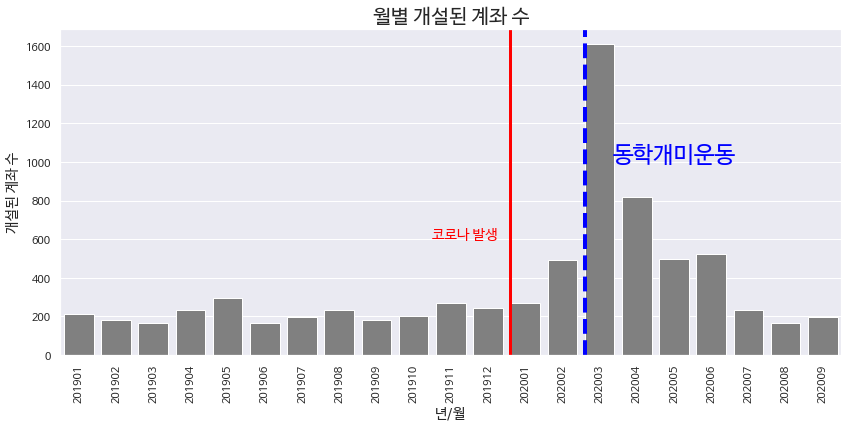

In [114]:
data = act_cus.groupby('act_opn_ym')['act_id'].count()[-22:-1]
x = data.index
y = data
sns.set_style(style = 'darkgrid')
plt.rc('font', family='NanumBarunGothic') 
fig, ax = plt.subplots(figsize = (14,6))

sns.barplot(x,y, color = 'grey')

ax.set_title('월별 개설된 계좌 수', fontsize = 20)

ax.set_ylabel('개설된 계좌 수', fontsize = 14)
ax.set_xlabel('년/월', fontsize = 14)
ax.set_xticklabels(x, rotation = 90)
ax.axvline(x= 11.6, color = 'red', lw = 3)
ax.annotate('코로나 발생', xy = (9.5, 600), fontsize = 14, color = 'red')
ax.axvline(x= 13.6, color = 'blue', lw = 4, ls = '--')
ax.annotate('동학개미운동', xy = (14.35, 1000), fontsize = 23, color = 'blue')
plt.savefig('월별 개설된 계좌 수.png', dpi = 300)
plt.show()

## 1. 전처리 작업 : 제공된 데이터를 베테랑과 주린이 두 집단으로 구분지어 분류하고 가정에 해당되는 투자자만 추출

####  1. **베테랑** : 2020년 이전부터 투자해온 숙련된 투자자
####  2. **주린이** : 2020년 코로나장때 유입된 초보 투자자

#### 가설 1 : 베테랑의 수익률이 주린이의 수익률보다 높을 것이다

가정 :
- 매매거래내역을 분석했을 때, 보유 주식 수량이 음수가 되는 순간이 있는 사람은 19년 이전부터 보유한 주식수가 있거나 다른 증권사에서 하다가 옮겨온 사람이므로 분석에 용이하지 않은 대상이므로 배제
- 마지막 거래내역의 주문날짜가 2020년인 사람만 해당(즉 2020년에도 거래한 사람)
- 계좌 하나만 보유한 사람(편의를 위해)

In [10]:
# 계산의 편의를 위해 매매구분코드에 따라 체결수량과 비용에 음수를 취해주고 매수의 매매구분코드를 0으로 변경
merge.loc[merge['매매구분코드'] == 1, '체결수량'] *= (-1) # 매도의 경우 체결 수량을 음수로
merge.loc[merge['매매구분코드'] == 2, '체결비용'] *= (-1) # 매수의 경우 체결 비용을 음수로
merge.loc[merge['매매구분코드'] == 2 , '매매구분코드'] = 0

In [11]:
# 2020년 개설 or 이전 개설한 계좌 수로 구분

act['2020년 개설'] = 0
act['2020년 이전 개설'] = 0

for i in range(len(act)):
    if act.loc[i,'act_opn_ym'] >= 202001:
        act.loc[i,'2020년 개설'] += 1
    else:
        act.loc[i,'2020년 이전 개설'] += 1
        
act_g = act.groupby(['cus_id'],as_index = False).agg({'2020년 개설' : 'sum', '2020년 이전 개설' : 'sum'})

# 주린이의 경우 : 20년 이전 개설 x 20년에 첫 개설
new_cus = act_g[(act_g['2020년 개설'] == 1) & (act_g['2020년 이전 개설'] == 0)]
# 베테랑의 경우 : 20 년 이전 개설한 계좌 수 1개
old_cus = act_g[(act_g['2020년 이전 개설'] == 1) & (act_g['2020년 개설'] == 0)]

In [12]:
# 고객 별 개설한 계좌 구분
act_g.head()

,cus_id,2020년 개설,2020년 이전 개설
0,0005485133f45a0074dc4588abe1ae0fb6b3dfebded28b...,1,0
1,000ffabe461b9b0f5360913aa1b340e84e44446617a8dc...,0,1
2,001b04c9eec677e2278040c51e01d262e72ce32ef25f00...,0,1
3,001ee721662751620282570981b2b4e2c1d42a8ef9329e...,0,2
4,001f5ef83673487f2abf25efdd61e284adcc1953001e69...,1,0


In [13]:
all_cus = pd.concat([new_cus, old_cus])

In [14]:
# 계좌 하나만 있는 사람들만 추출
clean_trd = merge.loc[merge['고객번호'].isin(all_cus['cus_id']), :]

In [15]:
# 마지막으로 거래한 날짜로부터 휴식시간을 알기 위해 제공된 데이터의 마지막 거래일인 7월 1일 기준으로 계산
import datetime
cus_date = clean_trd.sort_values(by = '주문날짜').drop_duplicates(subset = ['고객번호'], keep = 'last')
cus_date.loc[:, '주문날짜'] = pd.to_datetime(cus_date.loc[:,'주문날짜'])
cus_date.loc[:,'지난 시간'] = datetime.datetime(2020,7,1) - cus_date.loc[:, '주문날짜']
cus_date = cus_date.loc[:,['고객번호','지난 시간']]
cus_date_dict = {}
for i in range(len(cus_date)):
    cus_date_dict[cus_date.iloc[i,0]] = cus_date.iloc[i,1]
clean_trd.loc[:,'지난 시간'] = clean_trd['고객번호'].apply(lambda x : cus_date_dict[x])

C:\Users\msi\anaconda3\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [16]:
clean_trd.shape

(1170855, 29)

In [17]:
# 2020년 거래내역만 가져옴
clean_trd = clean_trd[clean_trd['년'] == 2020]

In [18]:
# 매매내역을 분석한 결과 매매 과정에서 보유 주식 수량이 음수가 되는 애들을 제외(20년 이전부터 보유한 주식이거나 다른 증권사에서 이주해온 경우이므로)
notnewlist = []
n = 0
for cus_id in clean_trd['고객번호'].unique():
    df = clean_trd[clean_trd['고객번호'] == cus_id]

    for iem_id in df['종목 한글명'].unique():
        df_2 = df[df['종목 한글명'] == iem_id].sort_values(by = ['주문날짜', '매매구분코드']).reset_index(drop = True)
        k = 0
        for j in range(len(df_2)):
            k += df_2.loc[j, '체결수량']
            if k < 0:
                notnewlist.append(cus_id)

In [19]:
clean_trd.shape

(710436, 29)

In [20]:
notnewlist = list(set(notnewlist))
len(notnewlist) # 제외되는 계좌 수 2205개

2205

In [21]:
clean_trd = clean_trd.drop(clean_trd[clean_trd['고객번호'].isin(notnewlist)].index) # 앞에 해당되는 계좌 제외

In [22]:
clean_trd['고객번호'].nunique()

2541

In [23]:
# y, z세대를 yz세대로 합쳐준 컬럼 추가
clean_trd['세대2'] = ''
clean_trd.loc[(clean_trd['세대'] == 'y') | (clean_trd['세대'] == 'z'), '세대2'] = 'yz'
clean_trd.loc[(clean_trd['세대'] == 'old'), '세대2'] = 'old'
clean_trd.loc[(clean_trd['세대'] == 'young'), '세대2'] = 'young'

In [24]:
# 2020년에도 거래내역이 있는 사람만
clean_trd = clean_trd[clean_trd['지난 시간'] < datetime.timedelta(182)]

In [25]:
# # 저장
# clean_trd.to_csv('clean_trd.csv')

In [26]:
# 베테랑과 주린이 거래내역 분류
real_new = clean_trd[clean_trd['고객번호'].isin(new_cus['cus_id'])]
real_old = clean_trd[clean_trd['고객번호'].isin(old_cus['cus_id'])]

In [27]:
real_old.head()

,계좌번호,주문순서,주문접수시간대,최종체결시간대,종목코드,매매구분코드,체결수량,체결가격,주문매체구분코드,주문날짜,...,성별,연령대,주소(시도),고객등급,고객투자성향,소요시간(최종체결시간대 - 주문접수시간대),년월,세대,지난 시간,세대2
14107,60937d1142e18d685cc690a30a2f2c0c332b0586e5e4da...,1,13,13,A034220,0,500.00,15700.00,3,2020-01-09,...,1,40,41,04,-,0,202001,old,82 days,old
14689,bc2c89d691a8e7f5bfac4bd4a118ccad7486ee7cc5261b...,1,9,9,A284430,0,45.00,11125.00,3,2020-01-21,...,1,0,11,09,04,0,202001,young,37 days,young
14745,e91ca17729743cbe33274a42b2805957829b394de0a38c...,1,9,9,A005935,0,2.00,51400.00,3,2020-01-22,...,2,40,11,09,-,0,202001,old,98 days,old
14793,dc25c2c36e466f098d8195861796790b0c434b2ab03ccb...,1,9,9,A005930,0,20.00,61100.00,3,2020-01-23,...,2,50,41,03,03,0,202001,old,21 days,old
14794,dc25c2c36e466f098d8195861796790b0c434b2ab03ccb...,2,9,13,A005930,0,20.00,60900.00,3,2020-01-23,...,2,50,41,03,03,4,202001,old,21 days,old


In [28]:
# 베테랑, 주린이 거래내역 합친 테이블
real_all = pd.concat([real_new,real_old])

In [29]:
print('주린이의 수는 {0}명이고\n베테랑의 수는 {1}명이다'.format(real_new['고객번호'].nunique(),real_old['고객번호'].nunique()))

주린이의 수는 1685명이고
베테랑의 수는 856명이다


In [30]:
# 각 종목마다 가장 마지막으로 거래된 가격을 저장
last_iem_price = {}
for i in range(len(merge)):
    last_iem_price[merge.loc[i,'종목 한글명']] = merge.loc[i,'체결가격']

## 고객의 운용 투자자금을 유추
##### 시작 투자자금을 0으로 했을 때, 매수건수가 있는데 해당 비용이 부족한 경우 투자자금에 그만큼 더해주는 식.
##### 예) -----------매수 100원 -> 매수 200원 -> 매도 400원 -> 매수 500원
##### 투자자금) 0원(시작) -> 100원    ->    300원    ->   300원    ->  400원 
##### -->> 즉 해당 고객의 투자자금은 400원

### 유추한 투자자금의 정확도를 알아보기 위해 실제 고객등급과 유추한 투자자금으로 추정한 고객등급을 비교해보았다

In [130]:
x = showmeprofit(clean_trd)
z = x[(x['tco_cus_grd_cd'] == '01') | (x['tco_cus_grd_cd'] == '02') | (x['tco_cus_grd_cd'] == '03')| (x['tco_cus_grd_cd'] == '04')| (x['tco_cus_grd_cd'] == '05')]

In [131]:
z.reset_index(drop = True, inplace = True)
y = z.copy()
y['class_label'] = ''
for i in range(len(y)):
    if y.loc[i, '투자자금'] < 30000000:
        y.loc[i,'class_label'] = '05'
    elif y.loc[i, '투자자금'] <= 100000000:
        y.loc[i,'class_label'] = '04'
    elif y.loc[i, '투자자금'] <= 300000000:
        y.loc[i,'class_label'] = '03'
    elif y.loc[i, '투자자금'] <= 1000000000:
        y.loc[i,'class_label'] = '02'
    elif y.loc[i, '투자자금'] > 1000000000:
        y.loc[i,'class_label'] = '01'

#### 유추한 투자자금으로 매긴 고객등급과 실제 고객등급의 차이를 비교해본 결과
#### 5개의 등급이 주어진 상황임을 고려했을 때 정확도 67% 로 그럭저럭 나쁘지 않은 결과가 나옴

In [33]:
y[['고객번호', '투자자금', 'tco_cus_grd_cd', 'class_label']].tail()

,고객번호,투자자금,tco_cus_grd_cd,class_label
1117,5ba37ca6d553c7ba7c1df3efa3ca38dc00543a6c8e32b7...,51996420.00,04,04
1118,a638551d75c193e8d3331d8e8ae2fd89c1ec7c18c1a1fe...,279648950.00,03,03
1119,f305bf95c6cc5cd48e048a49e2b87a9ed97f6fa3552c15...,597090000.00,02,02
1120,d6fd4427fda40fe44a213286d6ec58e8b42fa1c0d990cf...,700179800.00,02,02
1121,36fb6f2fe2f0570cc169d6fd537ed64d3f1168bf90e370...,2984527415.00,03,01


In [34]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y['tco_cus_grd_cd'], y['class_label']))

0.6666666666666666


### 베테랑과 주린이들의 투자자금을 아래 히스토그램과 박스플롯으로 나타냈을 때, 아웃라이어 값들이 매우 많음을 확인할 수 있었다.
### 이는, 투자에 있어서 운용하는 금액의 차이가 큰 영향을 미치므로 제거해주는 작업이 필요하다고 판단하였다

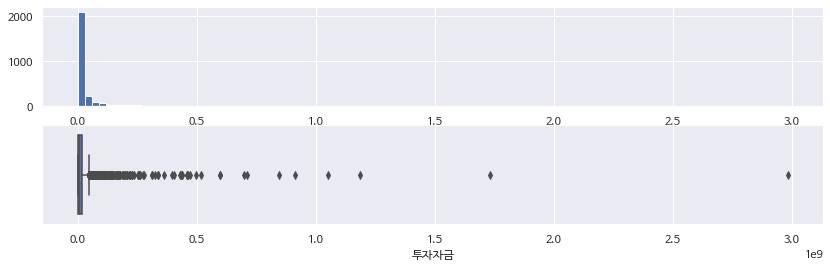

In [132]:
fig, ax = plt.subplots(figsize = (14, 4), nrows = 2)
x['투자자금'].hist(bins = 100, ax = ax[0])
sns.boxplot(data = x , x = '투자자금', ax = ax[1])
plt.savefig('투자자금 분포.png', dpi = 300)
plt.show()

### 일반적인 20대를 가정했을 때, 신한은행에서 발행한 보고서에 따르면
### 20대 미혼의 평균 자산이 9700이라는 결과와 투자자금의 박스플롯 최대값을 고려하여 **최대 5천만원 이하 최소 100만원 이상의 투자자들만 고려하였다**
##### https://www.insight.co.kr/news/314117

In [36]:
x['투자자금'] = x['투자자금'].astype(float)
Q1 = x.describe().loc['25%', '투자자금']
Q3 = x.describe().loc['75%', '투자자금']
IQR = Q3 - Q1
print(Q3 + 1.5*IQR)

46106250.0


In [37]:
# 운용자금 5천만원 이하 100만원 이상에 해당되는 고객들의 고객번호 리스트
cus_money = list(x[(x['투자자금'] < 50000000) & (x['투자자금'] > 1000000)]['고객번호'])

In [38]:
# 투자자금 5천만원 이하의 베테랑/주린이 거래내역
real_old_fn = real_old[real_old['고객번호'].isin(cus_money)]
real_new_fn = real_new[real_new['고객번호'].isin(cus_money)]
real_all_fn = pd.concat([real_old_fn, real_new_fn])

In [39]:
# 표본이 적은 미성년자는 제외해줌
real_all_fn = real_all_fn[real_all_fn['세대'] != 'young']

In [40]:
# 주린이, 베테랑 수익률, 투자자금 테이블
old_profit = profit_cus(real_old_fn)
new_profit = profit_cus(real_new_fn)

In [41]:
old_profit.head()

,고객번호,매수비용,총결산,수익률
0,003a6123b8701df16de38ef7fc3b1fb67773cedcf7c913...,9994800.00,1779400.00,17.80
1,00b2d5a8b33cfdd59c3f0af1fe875aa5b41cf353f10010...,2134000.00,215600.00,10.10
2,0153be2008eda6d0e38462fcaf035fbcbf6e9141ed33a9...,5355935.00,1232220.00,23.01
3,019cd81af319177630d08a14b7f2e266734f45147dffaa...,7920000.00,-2190000.00,-27.65
4,01fad41bba2f98e723e2f933db7cf59137a8f09694d442...,5669200.00,95700.00,1.69


In [42]:
# 고객의 세대 정보
cus_gen = clean_trd.drop_duplicates(subset = '고객번호', keep = 'first')[['고객번호', '세대', '지난 시간']]

In [43]:
# 세대 정보 추가
old_profit = pd.merge(old_profit, cus_gen, how = 'left', left_on = '고객번호', right_on = '고객번호')
new_profit = pd.merge(new_profit, cus_gen, how = 'left', left_on = '고객번호', right_on = '고객번호')

In [44]:
old_profit.head()

,고객번호,매수비용,총결산,수익률,세대,지난 시간
0,003a6123b8701df16de38ef7fc3b1fb67773cedcf7c913...,9994800.00,1779400.00,17.80,y,75 days
1,00b2d5a8b33cfdd59c3f0af1fe875aa5b41cf353f10010...,2134000.00,215600.00,10.10,y,51 days
2,0153be2008eda6d0e38462fcaf035fbcbf6e9141ed33a9...,5355935.00,1232220.00,23.01,y,27 days
3,019cd81af319177630d08a14b7f2e266734f45147dffaa...,7920000.00,-2190000.00,-27.65,y,160 days
4,01fad41bba2f98e723e2f933db7cf59137a8f09694d442...,5669200.00,95700.00,1.69,y,6 days


In [45]:
# 2020년 거래 수익률(베테랑, 주린이 통합)
real_all_profit = profit_cus(real_all_fn)

# 세대 정보 추가
real_all_profit = pd.merge(real_all_profit, cus_gen, how = 'left', left_on = '고객번호', right_on = '고객번호')
# 표본이 적은 미성년자 제외
real_all_profit = real_all_profit[real_all_profit['세대'] != 'young']

# 고객별 운용자금 컬럼 추가
cus_use_money = showmeprofit(real_all_fn)[['고객번호' ,'투자자금']]
real_all_profit = pd.merge(real_all_profit, cus_use_money,how = 'left', left_on = '고객번호', right_on = '고객번호')
real_all_profit['투자자금'] = real_all_profit['투자자금'].astype(float)

In [46]:
real_all_profit.head()

,고객번호,매수비용,총결산,수익률,세대,지난 시간,투자자금
0,003a6123b8701df16de38ef7fc3b1fb67773cedcf7c913...,9994800.00,1779400.00,17.80,y,75 days,9994800.00
1,006eea8d15906c421b52a3e96d4695e4f99e5e254269c1...,4978800.00,75600.00,1.52,y,2 days,4978800.00
2,00b2d5a8b33cfdd59c3f0af1fe875aa5b41cf353f10010...,2134000.00,215600.00,10.10,y,51 days,2134000.00
3,00cdddddb660b8eeaaa67e9ceed4610e7c3316ddf1f544...,304406919.00,4616687.00,1.52,y,1 days,31176046.00
4,00cf4c0d1799a4f2db8b0fcd7a77f7ad8268501577e80d...,15634400.00,35900.00,0.23,z,5 days,3916800.00


### 전체 투자자들의 선호 종목을 그려보았다
##### 선호종목 측정 : 2020년 거래내역을 토대로 고객별, 종목별 매수비용을 각각 더해준 후 고객마다 자금이 다르므로 MinMaxScaler로 스케일링 작업을 해준 후 각 종목별로 값을 더해줬다(함수참고)
- 삼성전자보통주가 공통적으로 큰 차이로 1등 선호 종목으로 자리 잡고 있다.
- 다음으로 현대자동차, 카카오, 에스케이하이닉스, 대한항공과 같은 우량주들이 공통적으로 상위에 위치
- 눈에 띄게 다른 점은 yz세대에서 나타나는 ETF 중 원유선물지수가 old세대에서는 나타나지 않는다는 점,
- 그리고 인버스/레버리지 상품이 old에서는 보이지 않는다는 점이 있다.
- 하이리스크 하이리턴이 특징인 인버스/레버리지에 젊은 사람들이 몰린 것이 그들의 공격적 투자성향을 대표해준다고 생각된다.

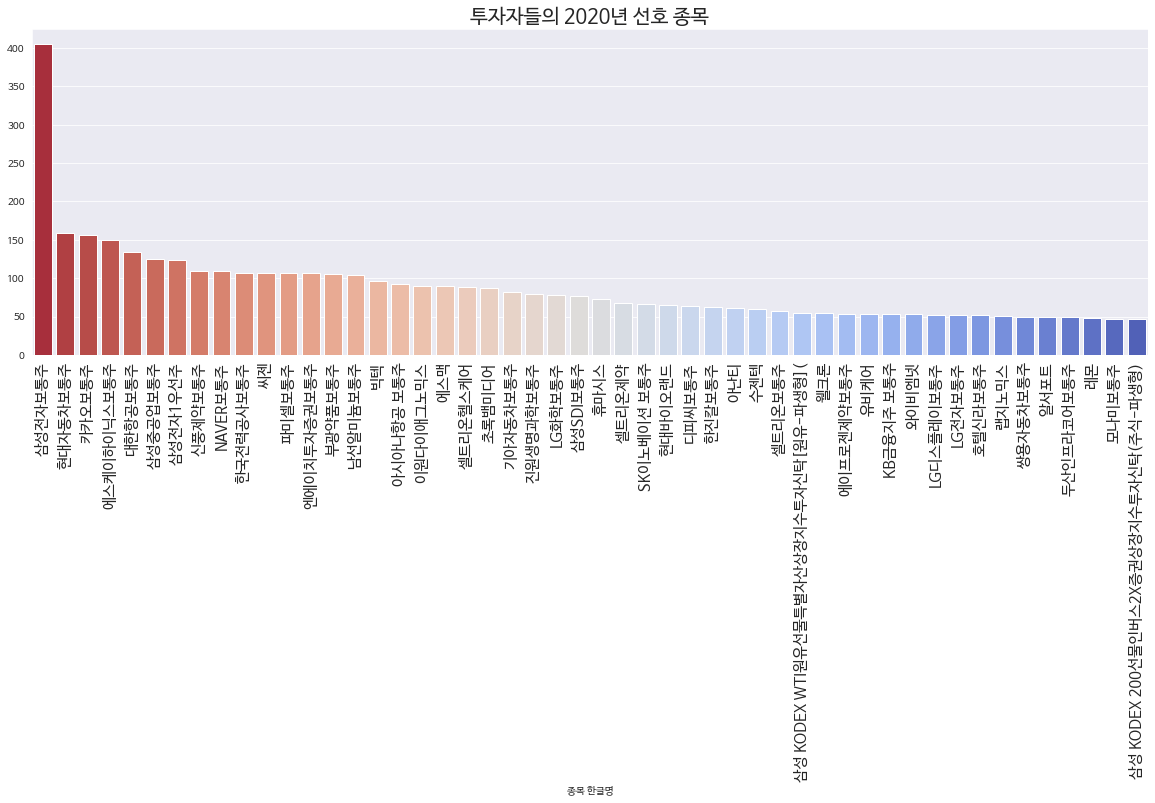

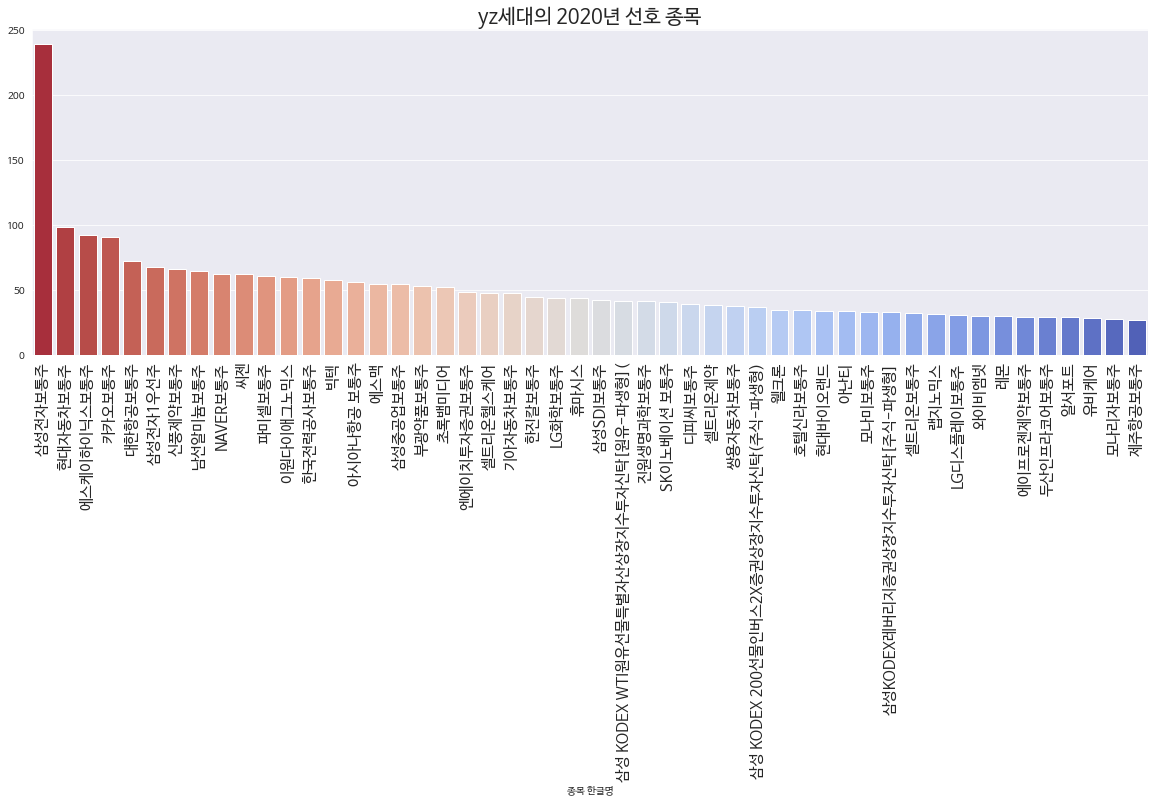

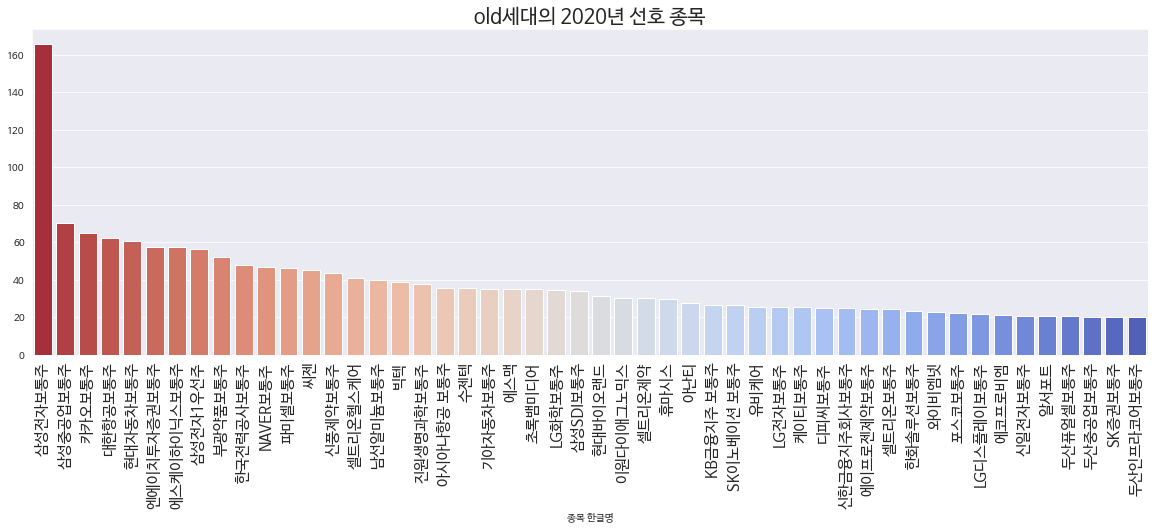

In [47]:
sns.set_style(style = 'darkgrid')
plt.rc('font', family='NanumBarunGothic') 
scale_plot(real_all_fn, MinMaxScaler(), '투자자들의 2020년 선호 종목', (20,6))
scale_plot(real_all_fn[(real_all_fn['세대'] == 'y') | (real_all_fn['세대'] == 'z')], MinMaxScaler(), 'yz세대의 2020년 선호 종목', (20,6)) 
scale_plot(real_all_fn[(real_all_fn['세대'] == 'old')], MinMaxScaler(), 'old세대의 2020년 선호 종목', (20,6))

### 투자자들의 주 운용 투자금액 분포는 대개 100만원 ~ 500만원 사이에 몰려있고 점차 감소한다

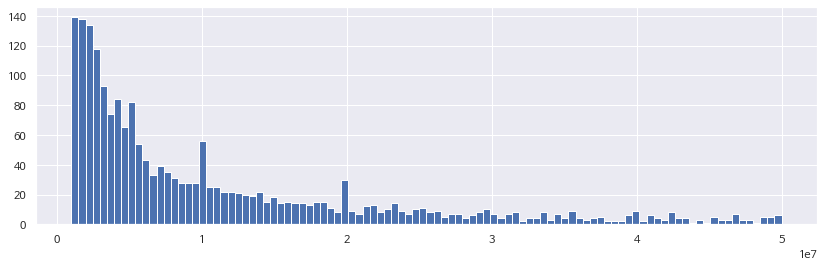

In [133]:
plt.figure(figsize = (14,4))
sns.set_style(style = 'darkgrid')
plt.rc('font', family='NanumBarunGothic') 
real_all_profit['투자자금'].hist(bins = 100)
plt.savefig('투자금액 분포후.png', dpi = 300)

# 2. 데이터 분석
## 2.1. 수익률 분석

#### **가설 1 : 베테랑의 수익률이 주린이의 수익률보다 높을 것이다**

### 주린이 : 베테랑의 수익률을 확률밀도함수로 보았을 때, 주린이가 베테랑보다 더 뾰족한 형태를 띈다.
#### -> 주린이의 수익률 편차가 더 적고 0%대에 몰려있어 안정적인 반면, 베테랑의 경우 손익편차가 주린이에 비해 크게 나타남

In [49]:
real_all_profit.loc[real_all_profit['고객번호'].isin(list(old_profit['고객번호'])), '베테랑'] = '베테랑'
real_all_profit.loc[real_all_profit['고객번호'].isin(list(new_profit['고객번호'])), '베테랑'] = '주린이'

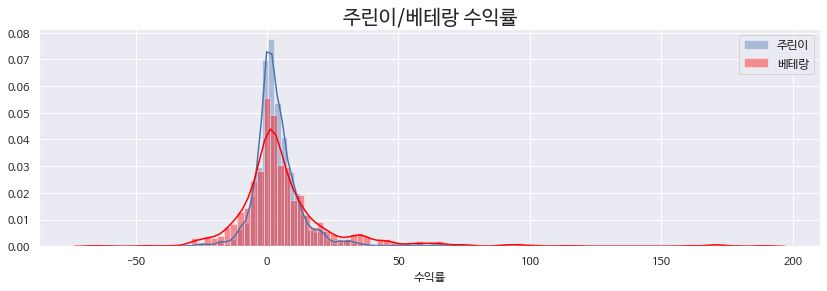

In [134]:
fig , ax = plt.subplots(figsize = (14,4))
sns.distplot(real_all_profit[real_all_profit['베테랑']=='주린이']['수익률'], label = '주린이', bins = 100)
sns.distplot(real_all_profit[real_all_profit['베테랑']=='베테랑']['수익률'], color = 'red',label = '베테랑', bins = 100)

ax.set_title('주린이/베테랑 수익률', fontsize = 20)
plt.legend(fontsize = 12)
plt.savefig('주린베테랑 ㅜㅅ이귤.png', dpi=300)
plt.show()

#### 베테랑/주린이, 세대별로 나눠서 수익률을 비교했을 때,
#### 전반적으로 베테랑의 수익이 주린이보다 3.5%가량 더 높고 y세대, old세대에서 더 높은 수치를 보인다.
#### 특히 old세대에서는 2~3배 가량 차이가 남을 확인할 수 있다.
#### 다만 특이하게 z세대의 경우 주린이가 1%가량 더 높은 수익률을 보인다

In [51]:
gen_list = [ 'z', 'y', 'old']

print('<베테랑들의 수익률>')
print('\n전 세대 평균은 {0:.2f}% 이다'.format(old_profit['수익률'].mean()))
for gen in gen_list:
    print('{0}세대의 표본은 {1}명으로 수익률 평균은 {2:.2f}% 이다'.format(gen, old_profit[old_profit['세대'] == gen]['고객번호'].nunique(),old_profit[old_profit['세대'] == gen]['수익률'].mean()))

print('\n<주린이들의 수익률>')
print('\n전 세대 평균은 {0:.2f}% 이다'.format(new_profit['수익률'].mean()))
for gen in gen_list:
    print('{0}세대의 표본은 {1}명으로 수익률 평균은 {2:.2f}% 이다'.format(gen, new_profit[new_profit['세대'] == gen]['고객번호'].nunique(), new_profit[new_profit['세대'] == gen]['수익률'].mean()))

<베테랑들의 수익률>

전 세대 평균은 7.67% 이다
z세대의 표본은 88명으로 수익률 평균은 3.83% 이다
y세대의 표본은 158명으로 수익률 평균은 5.38% 이다
old세대의 표본은 368명으로 수익률 평균은 9.69% 이다

<주린이들의 수익률>

전 세대 평균은 4.12% 이다
z세대의 표본은 374명으로 수익률 평균은 4.76% 이다
y세대의 표본은 371명으로 수익률 평균은 3.86% 이다
old세대의 표본은 656명으로 수익률 평균은 3.92% 이다


#### 두 집단의 수익률 차이가 유의미한지 검정하기 위해 T검정을 시행
#### T검정에 앞서 levene 방법으로 등분산 검정을 해본 결과 pvalue가 0.5 미만으로 등분산성을 기각하고 표본의 개수가 충분하므로
#### 이분산 가정 T검정을 시행하였다.

In [52]:
from scipy import stats
s, p = stats.levene(new_profit['수익률'], old_profit['수익률'])
print('leven 등분산 검정 결과 p_value값이 {0:.2f}로 0.05보다 작아 기존 귀무가설을 기각, 이분산을 가정한다'.format(p))
s, p = stats.ttest_ind(new_profit['수익률'], old_profit['수익률'], equal_var=False)
print('이분산 가정 T검정 결과 pvalue 값이 {0:.2f}로 0.05보다 작으므로 두 집단간의 수익률에 유의미한 차이가 있다'.format(p))

leven 등분산 검정 결과 p_value값이 0.00로 0.05보다 작아 기존 귀무가설을 기각, 이분산을 가정한다
이분산 가정 T검정 결과 pvalue 값이 0.00로 0.05보다 작으므로 두 집단간의 수익률에 유의미한 차이가 있다


#### **가설 1 : 베테랑의 수익률이 주린이의 수익률보다 높을 것이다 <- 검증**

#### **가설 2 : 세대간에 수익률 차이가 존재할 것이다**

In [53]:
# 주린이면 0 베테랑이면 1
real_all_profit['베테랑'] = ''
real_all_profit.loc[real_all_profit['고객번호'].isin(new_cus['cus_id']),'베테랑'] = '주린이'
real_all_profit.loc[real_all_profit['고객번호'].isin(old_cus['cus_id']),'베테랑'] = '베테랑'

In [54]:
real_all_profit['베테랑/세대'] = real_all_profit['베테랑'] + '/' + real_all_profit['세대']

In [137]:
real_all_profit.loc[(real_all_profit['세대'] == 'y') | (real_all_profit['세대'] == 'z'), '세대집합'] = 'yz'
real_all_profit.loc[(real_all_profit['세대'] == 'old'), '세대집합'] = 'old'

In [144]:
real_all_profit.loc[:,'베테랑/세대2'] = real_all_profit['베테랑'] + '/' + real_all_profit['세대집합']

In [145]:
real_all_profit

,고객번호,매수비용,총결산,수익률,세대,지난 시간,투자자금,베테랑,베테랑/세대,매매회전율,이탈기간,매수 종목 수,세대집합,베테랑/세대2
0,003a6123b8701df16de38ef7fc3b1fb67773cedcf7c913...,9994800.00,1779400.00,17.80,y,75 days,9994800.00,베테랑,베테랑/y,78.71,75,2,yz,베테랑/yz
1,006eea8d15906c421b52a3e96d4695e4f99e5e254269c1...,4978800.00,75600.00,1.52,y,2 days,4978800.00,주린이,주린이/y,50.00,2,1,yz,주린이/yz
2,00b2d5a8b33cfdd59c3f0af1fe875aa5b41cf353f10010...,2134000.00,215600.00,10.10,y,51 days,2134000.00,베테랑,베테랑/y,50.00,51,1,yz,베테랑/yz
3,00cdddddb660b8eeaaa67e9ceed4610e7c3316ddf1f544...,304406919.00,4616687.00,1.52,y,1 days,31176046.00,주린이,주린이/y,967.75,1,97,yz,주린이/yz
4,00cf4c0d1799a4f2db8b0fcd7a77f7ad8268501577e80d...,15634400.00,35900.00,0.23,z,5 days,3916800.00,주린이,주린이/z,349.16,5,18,yz,주린이/yz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010,ff5fac7369638b3ec0bdc218206cee5783af013907cef1...,31663950.00,1670800.00,5.28,old,12 days,10643250.00,주린이,주린이/old,255.49,12,6,old,주린이/old
2011,ff9ef0d1a94e6e1ea16654943e6ab5775eef2fc0cde6fd...,45906550.00,115385.00,0.25,z,1 days,21724115.00,주린이,주린이/z,177.55,1,22,yz,주린이/yz
2012,ffa66e795152e249e6848ccb8e06f71874b451c714fcc1...,33075990.00,-802865.00,-2.43,y,2 days,10203200.00,주린이,주린이/y,283.10,2,50,yz,주린이/yz
2013,ffc00d5d8de0fa381e72c6de7a4d77b3d01218cd2a9093...,3895135.00,338915.00,8.70,y,28 days,2942635.00,주린이,주린이/y,101.94,28,3,yz,주린이/yz


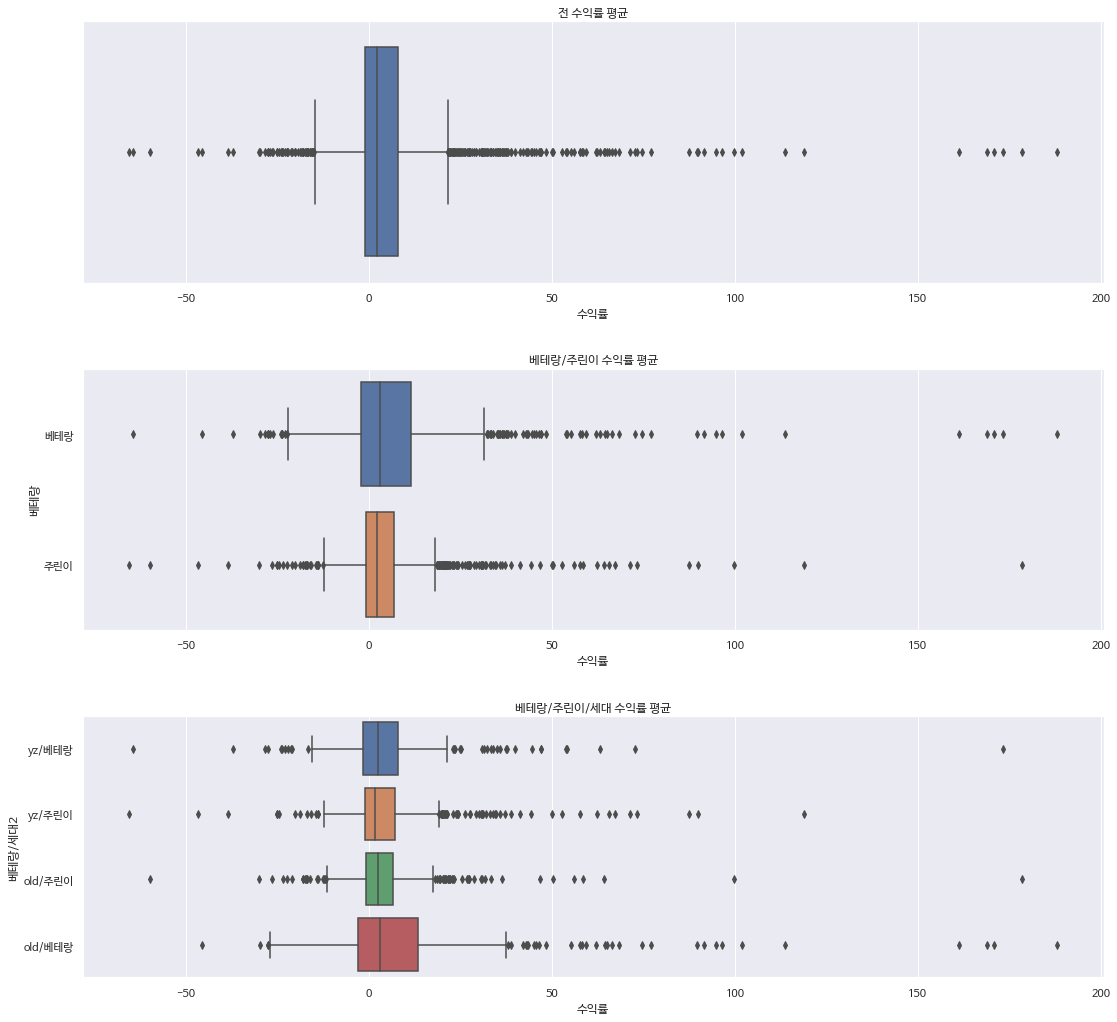

In [141]:
fig, ax = plt.subplots(figsize = (15,14), nrows = 3)
fig.tight_layout(h_pad = 5)
sns.boxplot(data = real_all_profit, x= '수익률', ax = ax[0])
sns.boxplot(data = real_all_profit, y = '베테랑', x = '수익률', ax = ax[1] )
sns.boxplot(data = real_all_profit, y = '베테랑/세대2', x = '수익률', ax = ax[2])
ax[0].set_title('전 수익률 평균')
ax[1].set_title('베테랑/주린이 수익률 평균')
ax[2].set_title('베테랑/주린이/세대 수익률 평균')
plt.savefig('세대 수익률.png', dpi = 300)
plt.show()

##### shapiro 정규성 검정 결과 정규성이 가긱되었고 등분산 검정을 시행해본 결과 등분산이 아니므로 Kruskal Wallis H를 사용하였다
##### Kruskal Wallis H 결과, pvalue가 0.01로 귀무가설 기각, 세대별 네 집단의 수익률에 통계적인 차이가 존재
##### 사후검정을 위해 Bonferonni 방법 채택
##### 유의수준 5%에서 그나마 베테랑/old 집단이 모든 주린이 집단과 유의미한 차이가 발견되었다

In [146]:
old_v_gr = real_all_profit[real_all_profit['베테랑/세대2'] == '베테랑/old']['수익률']
yz_v_gr = real_all_profit[real_all_profit['베테랑/세대2'] == '베테랑/yz']['수익률']
old_j_gr = real_all_profit[real_all_profit['베테랑/세대2'] == '주린이/old']['수익률']
yz_j_gr = real_all_profit[real_all_profit['베테랑/세대2'] == '주린이/yz']['수익률']

s, p = stats.levene(old_v_gr, yz_v_gr,  old_j_gr,yz_j_gr)
print('네 집단의 등분산 검정을 해본 결과 pvalue 값이 {0:.2f}로 유의수준 5%에서 등분산성이 기각되었다'.format(p))

네 집단의 등분산 검정을 해본 결과 pvalue 값이 0.00로 유의수준 5%에서 등분산성이 기각되었다


In [147]:
group = [old_v_gr, yz_v_gr,  old_j_gr,yz_j_gr]
for g in group:
    print('shapiro 정규성 검정 pvalue 값 ',stats.shapiro(g)[1])

shapiro 정규성 검정 pvalue 값  8.408178482368096e-25
shapiro 정규성 검정 pvalue 값  5.66763153088594e-20
shapiro 정규성 검정 pvalue 값  1.8789083336444212e-34
shapiro 정규성 검정 pvalue 값  1.1328583441984977e-33


In [148]:
from pingouin import welch_anova

aov = welch_anova(dv='수익률', between='베테랑/세대2', data=real_all_profit) 
aov 

,Source,ddof1,ddof2,F,p-unc,np2
0,베테랑/세대2,3,724.87,5.11,0.00,0.02


In [149]:
from statsmodels.sandbox.stats.multicomp import MultiComparison
import scipy.stats

comp = MultiComparison(real_all_profit['수익률'], real_all_profit['베테랑/세대2'])
result = comp.allpairtest(scipy.stats.ttest_ind, method='bonf')
result[0]

group1,group2,stat,pval,pval_corr,reject
베테랑/old,베테랑/yz,2.4758,0.0136,0.0814,False
베테랑/old,주린이/old,4.6933,0.0,0.0,True
베테랑/old,주린이/yz,4.5491,0.0,0.0,True
베테랑/yz,주린이/old,0.8495,0.3958,1.0,False
베테랑/yz,주린이/yz,0.4871,0.6263,1.0,False
주린이/old,주린이/yz,-0.592,0.554,1.0,False


### 세대간 수익률에는 통계학적으로 유의미한 차이가 존재하며 특히 베테랑/old 집단이 모든 주린이보다 3 ~ 4 % 높은 수익률을 보인다
#### **가설 2 : 세대간에 수익률 차이가 존재할 것이다 <- 검증**

## 2.2 투자자별 매매회전율 분석
#### **가설 3 : 세대 간 매매회전율에 차이가 존재할 것이다**
##### ※ 매매회전율 = 거래금액/(투자금액*2) *100%

In [60]:
# 매매회전율 컬럼 추가
real_all_profit = pd.merge(real_all_profit,turnover_ratio(real_all_fn)[['고객번호', '매매회전율']], how = 'left', left_on = '고객번호', right_on = '고객번호')

C:\Users\msi\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.8, the latest is 0.3.9.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [61]:
print('주린이의 평균 매매회전율은 {0:.1f} % 이고\n베테랑의 평균 매매회전율은 {1:.1f}%이다'.format(real_all_profit[real_all_profit['베테랑'] == '주린이']['매매회전율'].mean(),real_all_profit[real_all_profit['베테랑'] == '베테랑']['매매회전율'].mean()))

주린이의 평균 매매회전율은 167.6 % 이고
베테랑의 평균 매매회전율은 124.7%이다


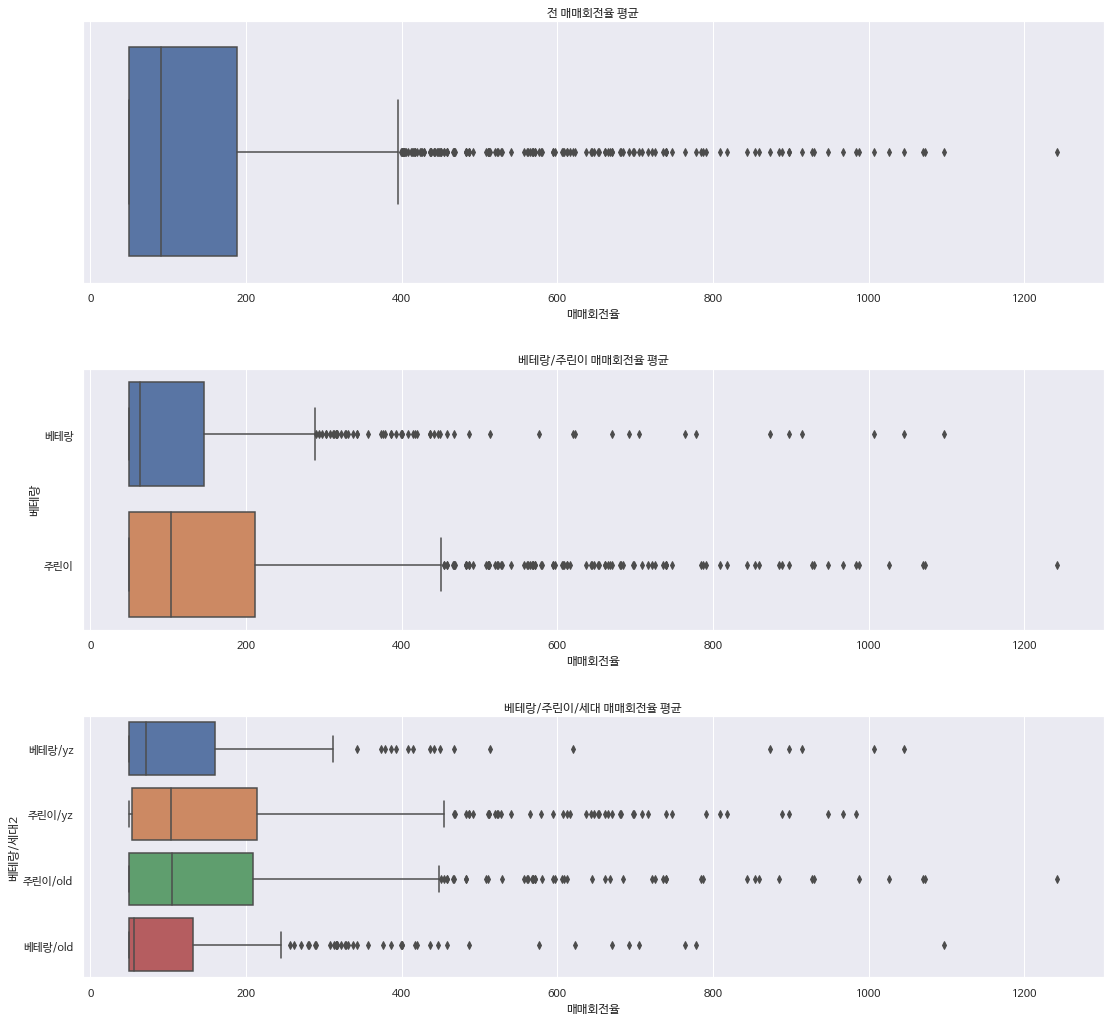

In [151]:
fig, ax = plt.subplots(figsize = (15,14), nrows = 3)
fig.tight_layout(h_pad = 5)
sns.boxplot(data = real_all_profit, x= '매매회전율', ax = ax[0])
sns.boxplot(data = real_all_profit, y = '베테랑',x = '매매회전율', ax = ax[1] )
sns.boxplot(data = real_all_profit, y = '베테랑/세대2', x = '매매회전율', ax = ax[2])
ax[0].set_title('전 매매회전율 평균')
ax[1].set_title('베테랑/주린이 매매회전율 평균')
ax[2].set_title('베테랑/주린이/세대 매매회전율 평균')
plt.savefig('세대 매매회전율.png', dpi = 300)
plt.show()

In [63]:
gen_list = [ 'z', 'y', 'old']

print('<베테랑들의 매매회전율>')
print('\n전 세대 평균은 {0:.2f}% 이다'.format(real_all_profit[(real_all_profit['베테랑'] == '베테랑')]['매매회전율'].mean()))
for gen in gen_list:
    print('{0}세대의 표본은 {1}명으로 매매회전율 평균은 {2:.2f}% 이다'.format(gen, real_all_profit[(real_all_profit['세대'] == gen) & (real_all_profit['베테랑'] == '베테랑')]['고객번호'].nunique(),real_all_profit[(real_all_profit['세대'] == gen) & (real_all_profit['베테랑'] == '베테랑')]['매매회전율'].mean()))

print('\n<주린이들의 매매회전율>')
print('\n전 세대 평균은 {0:.2f}% 이다'.format(real_all_profit[(real_all_profit['베테랑'] == '주린이')]['매매회전율'].mean()))
for gen in gen_list:
    print('{0}세대의 표본은 {1}명으로 매매회전율 평균은 {2:.2f}% 이다'.format(gen, real_all_profit[(real_all_profit['세대'] == gen) & (real_all_profit['베테랑'] == '주린이')]['고객번호'].nunique(), real_all_profit[(real_all_profit['세대'] == gen) & (real_all_profit['베테랑'] == '주린이')]['매매회전율'].mean()))

<베테랑들의 매매회전율>

전 세대 평균은 124.69% 이다
z세대의 표본은 88명으로 매매회전율 평균은 138.67% 이다
y세대의 표본은 158명으로 매매회전율 평균은 134.35% 이다
old세대의 표본은 368명으로 매매회전율 평균은 117.20% 이다

<주린이들의 매매회전율>

전 세대 평균은 167.55% 이다
z세대의 표본은 374명으로 매매회전율 평균은 160.75% 이다
y세대의 표본은 371명으로 매매회전율 평균은 173.31% 이다
old세대의 표본은 656명으로 매매회전율 평균은 168.18% 이다


In [64]:
s, p = stats.levene(real_all_profit[real_all_profit['베테랑'] == '베테랑']['매매회전율'], real_all_profit[real_all_profit['베테랑'] == '주린이']['매매회전율'])
print('leven 등분산 검정 결과 p_value값이 {0:.2f}로 0.05보다 작아 기존 귀무가설을 기각, 이분산을 가정한다'.format(p))
s, p = stats.ttest_ind(real_all_profit[real_all_profit['베테랑'] == '베테랑']['매매회전율'], real_all_profit[real_all_profit['베테랑'] == '주린이']['매매회전율'], equal_var=False)
print('이분산 가정 T검정 결과 pvalue 값이 {0:.2f}로 0.05보다 작으므로 두 집단간의 수익률에 유의미한 차이가 있다'.format(p))

leven 등분산 검정 결과 p_value값이 0.00로 0.05보다 작아 기존 귀무가설을 기각, 이분산을 가정한다
이분산 가정 T검정 결과 pvalue 값이 0.00로 0.05보다 작으므로 두 집단간의 수익률에 유의미한 차이가 있다


In [152]:
old_v_gr = real_all_profit[real_all_profit['베테랑/세대2'] == '베테랑/old']['매매회전율']
yz_v_gr = real_all_profit[real_all_profit['베테랑/세대2'] == '베테랑/yz']['매매회전율']
old_j_gr = real_all_profit[real_all_profit['베테랑/세대2'] == '주린이/old']['매매회전율']
yz_j_gr = real_all_profit[real_all_profit['베테랑/세대2'] == '주린이/yz']['매매회전율']

s, p = stats.levene(old_v_gr, yz_v_gr,  old_j_gr,yz_j_gr)
print('네 집단의 등분산 검정을 해본 결과 pvalue 값이 {0:.2f}로 유의수준 5%에서 등분산성이 기각되었다'.format(p))

네 집단의 등분산 검정을 해본 결과 pvalue 값이 0.00로 유의수준 5%에서 등분산성이 기각되었다


In [153]:
group = [old_v_gr, yz_v_gr, old_j_gr,yz_j_gr]
for g in group:
    print('shapiro 정규성 검정 pvalue 값 ',stats.shapiro(g)[1])

shapiro 정규성 검정 pvalue 값  5.437241483717188e-29
shapiro 정규성 검정 pvalue 값  6.4044055187906876e-24
shapiro 정규성 검정 pvalue 값  4.4538173215191184e-33
shapiro 정규성 검정 pvalue 값  9.25536497379467e-33


In [154]:
aov = welch_anova(dv='매매회전율', between='베테랑/세대2', data=real_all_profit) 
aov 

,Source,ddof1,ddof2,F,p-unc,np2
0,베테랑/세대2,3,832.72,13.57,0.00,0.02


In [155]:
comp = MultiComparison(real_all_profit['매매회전율'], real_all_profit['베테랑/세대2'])
result = comp.allpairtest(scipy.stats.ttest_ind, method='bonf')
result[0]

group1,group2,stat,pval,pval_corr,reject
베테랑/old,베테랑/yz,-1.6177,0.1062,0.6375,False
베테랑/old,주린이/old,-4.8577,0.0,0.0,True
베테랑/old,주린이/yz,-5.1926,0.0,0.0,True
베테랑/yz,주린이/old,-2.5354,0.0114,0.0684,False
베테랑/yz,주린이/yz,-2.6745,0.0076,0.0456,True
주린이/old,주린이/yz,0.1309,0.8959,1.0,False


In [69]:
real_all_profit[['매매회전율', '수익률']].corr()

,매매회전율,수익률
매매회전율,1.00,-0.11
수익률,-0.11,1.00


#### 주린이가 베테랑보다 40% 정도 더 높은 매매회전율을 보이고 old/베테랑이 모든 주린이 세대보다 50% 가량 낮은 매매회전율을 보인다
#### 위에서 베테랑/old가 가장 높은 수익률을 보인 것을 보았을 때, 잦은 매매가 꼭 좋은 것만은 아닌거 같다(단타 < 장타)
#### 이에 약하지만 매매회전율과 수익률간에는 -0.11의 음의 선형 상관관계가 발견됐다

#### **가설 3 : 세대 간 매매회전율에 차이가 존재할 것이다 <- 검증**

## 2.3 세대별 이탈 기간 분석
### 수익률과 마찬가지 방법으로 세대간 이탈기간의 차이를 분석해보았다
#### **가설 4 : 세대 간 이탈기간에 차이가 존재할 것이다**

In [70]:
real_all_profit['이탈기간'] = real_all_profit['지난 시간'].apply(lambda x : x.days)

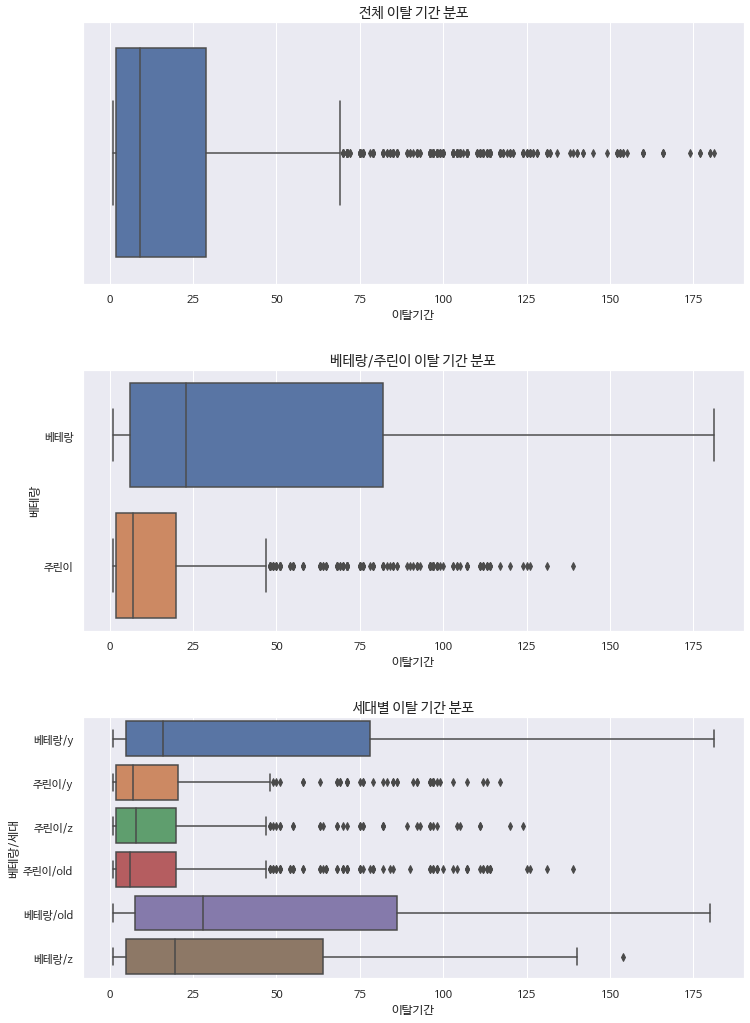

In [156]:
fig, ax = plt.subplots(figsize = (10,14), nrows = 3)
fig.tight_layout(h_pad = 5)
sns.boxplot(data = real_all_profit, x = '이탈기간', ax = ax[0])
sns.boxplot(data = real_all_profit, y = '베테랑/세대', x = '이탈기간' , ax = ax[2])
sns.boxplot(data = real_all_profit, y = '베테랑', x = '이탈기간' , ax = ax[1])
ax[0].set_title('전체 이탈 기간 분포', fontsize = 14)
ax[2].set_title('세대별 이탈 기간 분포', fontsize = 14)
ax[1].set_title('베테랑/주린이 이탈 기간 분포', fontsize = 14)
plt.savefig('이탈기간.png', dpi = 300)
plt.show()

#### 앞에와 마찬가지로 정규성, 등분산성을 검정해본 결과 둘다 성립하지 않았다.
##### Kruskal Wallis H 결과, pvalue가 0.05 미만으로 귀무가설 기각, 세대별 집단의 이탈기간에 통계적인 차이가 존재
##### 사후검정을 위해 Bonferonni 방법 채택
##### 유의수준 5%에서 그나마 베테랑/old 집단이 주린이 중에서 old, y, z 집단과 유의미한 차이가 발견되었다

In [72]:
gen_list = [ '주린이/z', '주린이/y', '주린이/old',  '베테랑/z', '베테랑/y', '베테랑/old']

print('<세대/베테랑 별 이탈기간>')
print('\n전 집단 평균은 {0:.2f}일 이다'.format(real_all_profit['이탈기간'].mean()))
for gen in gen_list:
    print('{0}세대의 표본은 {1}명으로 이탈기간 평균은 {2:.2f}일 이다'.format(gen, real_all_profit[real_all_profit['베테랑/세대'] == gen]['고객번호'].nunique(),real_all_profit[real_all_profit['베테랑/세대'] == gen]['이탈기간'].mean()))

<세대/베테랑 별 이탈기간>

전 집단 평균은 25.76일 이다
주린이/z세대의 표본은 374명으로 이탈기간 평균은 16.93일 이다
주린이/y세대의 표본은 371명으로 이탈기간 평균은 18.90일 이다
주린이/old세대의 표본은 656명으로 이탈기간 평균은 16.99일 이다
베테랑/z세대의 표본은 88명으로 이탈기간 평균은 37.69일 이다
베테랑/y세대의 표본은 158명으로 이탈기간 평균은 42.65일 이다
베테랑/old세대의 표본은 368명으로 이탈기간 평균은 47.20일 이다


In [159]:
s, p = stats.levene(real_all_profit[real_all_profit['베테랑'] == '베테랑']['이탈기간'], real_all_profit[real_all_profit['베테랑'] == '주린이']['이탈기간'])
print('leven 등분산 검정 결과 p_value값이 {0:.2f}로 0.05보다 작아 기존 귀무가설을 기각, 이분산을 가정한다'.format(p))
s, p = stats.ttest_ind(real_all_profit[real_all_profit['베테랑'] == '베테랑']['이탈기간'], real_all_profit[real_all_profit['베테랑'] == '주린이']['이탈기간'], equal_var=False)
print('이분산 가정 T검정 결과 pvalue 값이 {0:.2f}로 0.05보다 작으므로 두 집단간의 이탈기간에 유의미한 차이가 있다'.format(p))

leven 등분산 검정 결과 p_value값이 0.00로 0.05보다 작아 기존 귀무가설을 기각, 이분산을 가정한다
이분산 가정 T검정 결과 pvalue 값이 0.00로 0.05보다 작으므로 두 집단간의 이탈기간에 유의미한 차이가 있다


In [160]:
old_v_gr = real_all_profit[real_all_profit['베테랑/세대2'] == '베테랑/old']['이탈기간']
yz_v_gr = real_all_profit[real_all_profit['베테랑/세대2'] == '베테랑/yz']['이탈기간']

old_j_gr = real_all_profit[real_all_profit['베테랑/세대2'] == '주린이/old']['이탈기간']
yz_j_gr = real_all_profit[real_all_profit['베테랑/세대2'] == '주린이/yz']['이탈기간']


s, p = stats.levene(old_v_gr, yz_v_gr,  old_j_gr,yz_j_gr)
print('네 집단의 등분산 검정을 해본 결과 pvalue 값이 {0:.2f}로 유의수준 5%에서 등분산성이 기각되었다'.format(p))

네 집단의 등분산 검정을 해본 결과 pvalue 값이 0.00로 유의수준 5%에서 등분산성이 기각되었다


In [161]:
group = [old_v_gr, yz_v_gr, old_j_gr,yz_j_gr]
for g in group:
    print('shapiro 정규성 검정 pvalue 값 ',stats.shapiro(g)[1])

shapiro 정규성 검정 pvalue 값  1.0016492164804673e-17
shapiro 정규성 검정 pvalue 값  4.9568801515962634e-17
shapiro 정규성 검정 pvalue 값  2.408454074599217e-34
shapiro 정규성 검정 pvalue 값  5.730813910578231e-35


In [162]:
aov = welch_anova(dv='이탈기간', between='베테랑/세대2', data=real_all_profit) 
aov 

,Source,ddof1,ddof2,F,p-unc,np2
0,베테랑/세대2,3,714.48,61.93,0.00,0.13


In [163]:
comp = MultiComparison(real_all_profit['이탈기간'], real_all_profit['베테랑/세대2'])
result = comp.allpairtest(scipy.stats.ttest_ind, method='bonf')
result[0]

group1,group2,stat,pval,pval_corr,reject
베테랑/old,베테랑/yz,1.633,0.103,0.6179,False
베테랑/old,주린이/old,13.3836,0.0,0.0,True
베테랑/old,주린이/yz,13.6309,0.0,0.0,True
베테랑/yz,주린이/old,9.7243,0.0,0.0,True
베테랑/yz,주린이/yz,9.7853,0.0,0.0,True
주린이/old,주린이/yz,-0.6872,0.4921,1.0,False


### old와 y세대를 제외하고는 모든 세대간 이탈기간에는 유의미한 차이가 존재한다
#### 주린이들의 이탈기간이 베테랑에 비해 20일 가량 적었다. 처음 생각으로는 주린이가 오히려 더 떠나간 사람이 많을 것으로 생각됐는데 상반되는 결과가 나왔다
#### **가설 3 : 세대 간 이탈기간에 차이가 존재할 것이다** <- 검증 완료

In [77]:
real_all_profit.head()

,고객번호,매수비용,총결산,수익률,세대,지난 시간,투자자금,베테랑,베테랑/세대,매매회전율,이탈기간
0,003a6123b8701df16de38ef7fc3b1fb67773cedcf7c913...,9994800.00,1779400.00,17.80,y,75 days,9994800.00,베테랑,베테랑/y,78.71,75
1,006eea8d15906c421b52a3e96d4695e4f99e5e254269c1...,4978800.00,75600.00,1.52,y,2 days,4978800.00,주린이,주린이/y,50.00,2
2,00b2d5a8b33cfdd59c3f0af1fe875aa5b41cf353f10010...,2134000.00,215600.00,10.10,y,51 days,2134000.00,베테랑,베테랑/y,50.00,51
3,00cdddddb660b8eeaaa67e9ceed4610e7c3316ddf1f544...,304406919.00,4616687.00,1.52,y,1 days,31176046.00,주린이,주린이/y,967.75,1
4,00cf4c0d1799a4f2db8b0fcd7a77f7ad8268501577e80d...,15634400.00,35900.00,0.23,z,5 days,3916800.00,주린이,주린이/z,349.16,5


## 소론:
### 수익률, 매매회전율, 이탈기간에서 모두 집단간, 베테랑/주린이간 유의미한 차이가 존재한다는 것을 알 수 있었다. 또한 수익률의 경우 베테랑이 주린이보다 3.5% 가량 높았으며 특히 베테랑 중에서도 old 세대의 수익률이 다른 주린이들에 비해 큰 차이로 높았다. 매매회전율 같은 경우에는 주린이가 베테랑보다 40% 가량 더 높은 수치를 보였으며 주목할만한 점은 베테랑/old의 경우 큰 차이로 수익률이 높았지만 반대로 매매회전율 측면에서는 낮은 경향을 보였다. 이에 두 요인간에 상관관계분석을 해본 결과 -0.11로 작지만 음의 상관관계를 확인할 수 있었다. 마지막으로 이탈기간의 경우, 베테랑이 주린이보다 20일 가량 더 길었으며 이것이 장투의 영향인지 정말 이탈한 것인지는 추후 추가적인 분석이 필요할 것으로 보인다 

## 3. 주린이/베테랑 yz/old 구분 투자자 K-means 군집분석
#### 사용한 변수 :
- 수익률(%) = (매매비용 결산) / (매수비용) * 100
- 매매회전율(%) = (매매비용 총합)/(투자금액*2) * 100
- 투자자금(원)
- 매수 종목 수(개)
- 이탈기간(일)(2020년 7월1일 기준 마지막 거래일과 비교)

#### 군집분석 이전 선행작업:
- (원), (%), (개) 등의 수준을 맞춰주기 위한 스케일링 작업(MinMaxScaler 사용)
- elbow를 통한 적정 군집수 책정 (4개 집단 모두 4개의 군집을 적정수로 정함)

##### y,z세대 주린이 / y,z세대 베테랑 / old세대 주린이 / old세대 베테랑 네 집단을 각각 클러스터링해주고 비교

In [78]:
num_buy_iem = real_all_fn.drop_duplicates(subset = ['고객번호', '종목 한글명']).groupby(['고객번호'],as_index = False)['종목 한글명'].count()
num_buy_iem.rename(columns = {'종목 한글명' : '매수 종목 수'},inplace = True)
real_all_profit = pd.merge(real_all_profit, num_buy_iem , how = 'left', left_on = '고객번호', right_on = '고객번호')

In [164]:
real_all_profit.head()[['고객번호','수익률','지난 시간', '투자자금','매매회전율','이탈기간','매수 종목 수']]

,고객번호,수익률,지난 시간,투자자금,매매회전율,이탈기간,매수 종목 수
0,003a6123b8701df16de38ef7fc3b1fb67773cedcf7c913...,17.80,75 days,9994800.00,78.71,75,2
1,006eea8d15906c421b52a3e96d4695e4f99e5e254269c1...,1.52,2 days,4978800.00,50.00,2,1
2,00b2d5a8b33cfdd59c3f0af1fe875aa5b41cf353f10010...,10.10,51 days,2134000.00,50.00,51,1
3,00cdddddb660b8eeaaa67e9ceed4610e7c3316ddf1f544...,1.52,1 days,31176046.00,967.75,1,97
4,00cf4c0d1799a4f2db8b0fcd7a77f7ad8268501577e80d...,0.23,5 days,3916800.00,349.16,5,18


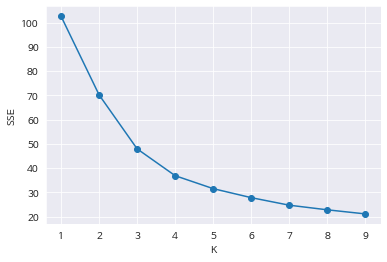

In [80]:
# y,z세대 주린이 경우
mmScaler = MinMaxScaler()
from sklearn.cluster import KMeans
kmeans = KMeans()
x = real_all_profit.loc[((real_all_profit['세대'] == 'y')  & (real_all_profit['베테랑'] == '주린이'))| ((real_all_profit['세대'] == 'z') & (real_all_profit['베테랑'] == '주린이')),:][['수익률','매수 종목 수', '이탈기간', '매매회전율', '투자자금']]
y = real_all_profit.loc[((real_all_profit['세대'] == 'y')  & (real_all_profit['베테랑'] == '주린이'))| ((real_all_profit['세대'] == 'z') & (real_all_profit['베테랑'] == '주린이')),:]
x = pd.DataFrame(mmScaler.fit_transform(x),columns = x.columns)
elbow(x)

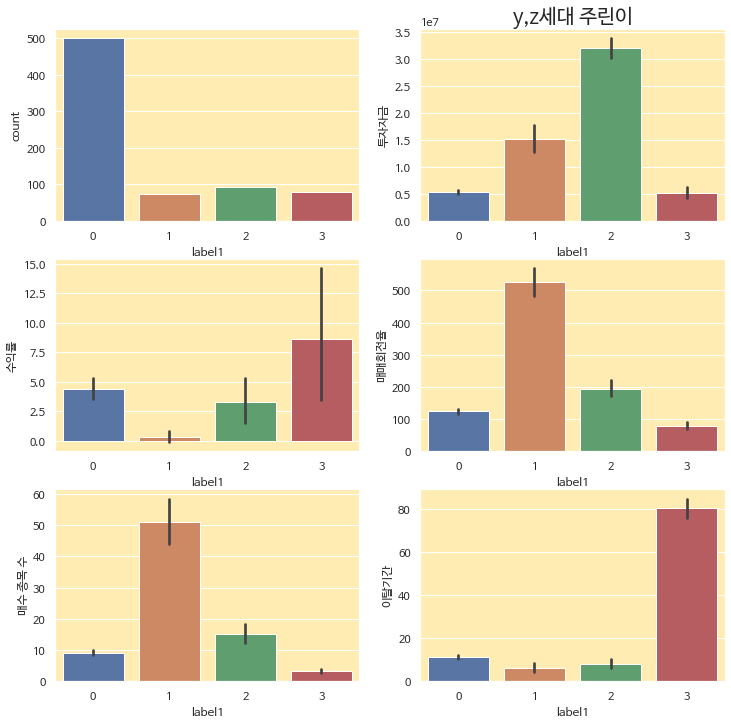

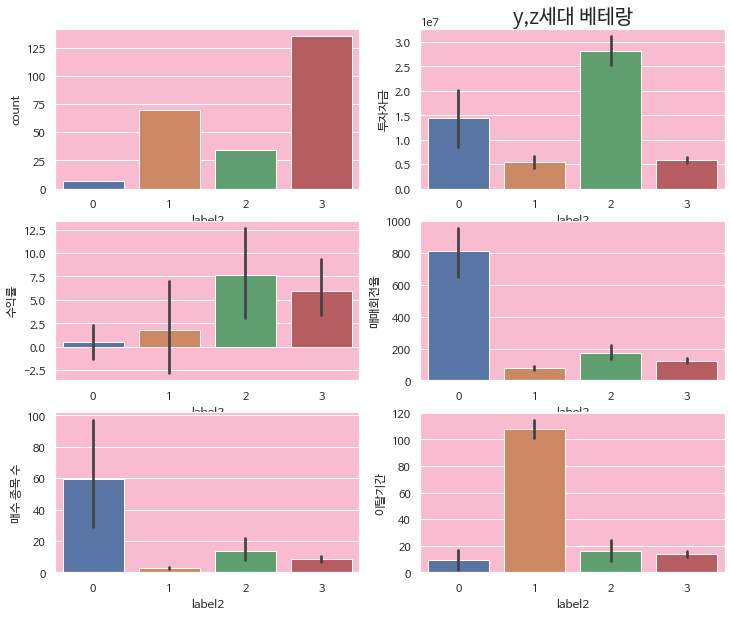

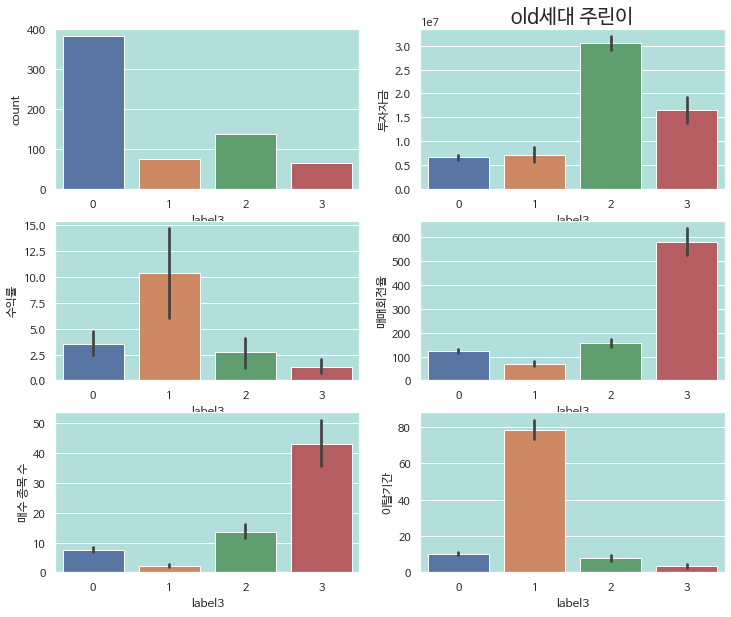

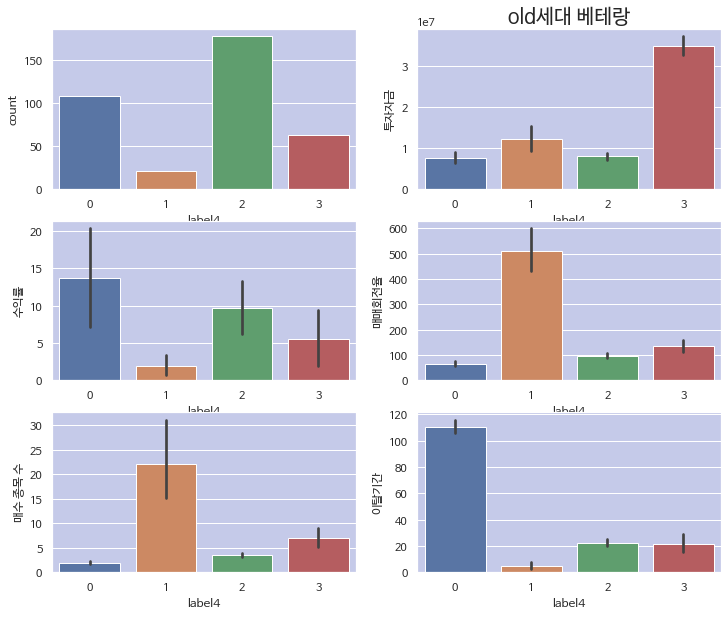

In [81]:
mmScaler = MinMaxScaler()

x = real_all_profit.loc[((real_all_profit['세대'] == 'y')  & (real_all_profit['베테랑'] == '주린이'))| ((real_all_profit['세대'] == 'z') & (real_all_profit['베테랑'] == '주린이')),:][['수익률','매수 종목 수', '이탈기간', '매매회전율', '투자자금']]
y = real_all_profit.loc[((real_all_profit['세대'] == 'y')  & (real_all_profit['베테랑'] == '주린이'))| ((real_all_profit['세대'] == 'z') & (real_all_profit['베테랑'] == '주린이')),:]
x = pd.DataFrame(mmScaler.fit_transform(x),columns = x.columns)
kmeans = KMeans(n_clusters = 4, random_state = 100)
kmeans.fit(x)
z1 = y.copy()
z1.loc[:,'label1'] = kmeans.labels_

sns.set(rc={'axes.facecolor':'#ffecb3', 'figure.facecolor':'white'})
plt.rc('font', family='NanumBarunGothic') 
fig, ax = plt.subplots(figsize = (12,12), ncols = 2, nrows = 3)

sns.countplot(data = z1 , x = 'label1', ax = ax[0][0])
sns.barplot(data = z1 , x = 'label1', y = '투자자금', ax = ax[0][1])
sns.barplot(data = z1 , x = 'label1', y = '수익률', ax = ax[1][0])
sns.barplot(data = z1 , x = 'label1', y = '매매회전율', ax = ax[1][1])
sns.barplot(data = z1 , x = 'label1', y = '매수 종목 수', ax = ax[2][0])
sns.barplot(data = z1 , x = 'label1', y = '이탈기간', ax = ax[2][1])
ax[0][1].set_title('y,z세대 주린이', fontsize = 20)
plt.show()

x = real_all_profit.loc[((real_all_profit['세대'] == 'y')  & (real_all_profit['베테랑'] == '베테랑'))| ((real_all_profit['세대'] == 'z') & (real_all_profit['베테랑'] == '베테랑')),:][['수익률','매수 종목 수', '이탈기간', '매매회전율', '투자자금']]
y = real_all_profit.loc[((real_all_profit['세대'] == 'y')  & (real_all_profit['베테랑'] == '베테랑'))| ((real_all_profit['세대'] == 'z') & (real_all_profit['베테랑'] == '베테랑')),:]
x = pd.DataFrame(mmScaler.fit_transform(x),columns = x.columns)
kmeans = KMeans(n_clusters = 4, random_state = 100)
kmeans.fit(x)
z2 = y.copy()
z2.loc[:,'label2'] = kmeans.labels_

sns.set(rc={'axes.facecolor':'#f8bbd0', 'figure.facecolor':'white'})
plt.rc('font', family='NanumBarunGothic')
fig, ax = plt.subplots(figsize = (12,10), ncols = 2, nrows = 3)
sns.countplot(data = z2 , x = 'label2', ax = ax[0][0])
sns.barplot(data = z2 , x = 'label2', y = '투자자금', ax = ax[0][1])
sns.barplot(data = z2 , x = 'label2', y = '수익률', ax = ax[1][0])
sns.barplot(data = z2 , x = 'label2', y = '매매회전율', ax = ax[1][1])
sns.barplot(data = z2 , x = 'label2', y = '매수 종목 수', ax = ax[2][0])
sns.barplot(data = z2 , x = 'label2', y = '이탈기간', ax = ax[2][1])
ax[0][1].set_title('y,z세대 베테랑', fontsize = 20)

plt.show()

x = real_all_profit.loc[((real_all_profit['세대'] == 'old')  & (real_all_profit['베테랑'] == '주린이')),:][['수익률','매수 종목 수', '이탈기간', '매매회전율', '투자자금']]
y = real_all_profit.loc[((real_all_profit['세대'] == 'old')  & (real_all_profit['베테랑'] == '주린이')),:]
x = pd.DataFrame(mmScaler.fit_transform(x),columns = x.columns)
kmeans = KMeans(n_clusters = 4, random_state = 100)
kmeans.fit(x)
z3 = y.copy()
z3.loc[:,'label3'] = kmeans.labels_

sns.set(rc={'axes.facecolor':'#b2dfdb', 'figure.facecolor':'white'})
plt.rc('font', family='NanumBarunGothic')
fig, ax = plt.subplots(figsize = (12,10), ncols = 2, nrows = 3)
sns.countplot(data = z3 , x = 'label3', ax = ax[0][0])
sns.barplot(data = z3 , x = 'label3', y = '투자자금', ax = ax[0][1])
sns.barplot(data = z3 , x = 'label3', y = '수익률', ax = ax[1][0])
sns.barplot(data = z3 , x = 'label3', y = '매매회전율', ax = ax[1][1])
sns.barplot(data = z3 , x = 'label3', y = '매수 종목 수', ax = ax[2][0])
sns.barplot(data = z3 , x = 'label3', y = '이탈기간', ax = ax[2][1])
ax[0][1].set_title('old세대 주린이', fontsize =20)
plt.show()

x = real_all_profit.loc[((real_all_profit['세대'] == 'old')  & (real_all_profit['베테랑'] == '베테랑')),:][['수익률','매수 종목 수', '이탈기간', '매매회전율', '투자자금']]
y = real_all_profit.loc[((real_all_profit['세대'] == 'old')  & (real_all_profit['베테랑'] == '베테랑')),:]
x = pd.DataFrame(mmScaler.fit_transform(x),columns = x.columns)
kmeans = KMeans(n_clusters = 4, random_state = 100)
kmeans.fit(x)
z4 = y.copy()
z4.loc[:,'label4'] = kmeans.labels_

sns.set(rc={'axes.facecolor':'#c5cae9', 'figure.facecolor':'white'})
plt.rc('font', family='NanumBarunGothic')
fig, ax = plt.subplots(figsize = (12,10), ncols = 2, nrows = 3)
sns.countplot(data = z4 , x = 'label4', ax = ax[0][0])
sns.barplot(data = z4 , x = 'label4', y = '투자자금', ax = ax[0][1])
sns.barplot(data = z4 , x = 'label4', y = '수익률', ax = ax[1][0])
sns.barplot(data = z4 , x = 'label4', y = '매매회전율', ax = ax[1][1])
sns.barplot(data = z4 , x = 'label4', y = '매수 종목 수', ax = ax[2][0])
sns.barplot(data = z4 , x = 'label4', y = '이탈기간', ax = ax[2][1])
ax[0][1].set_title('old세대 베테랑', fontsize = 20)
plt.show()

## 주린이/베테랑 yz/old 세대  군집분석 결과

### 기본적으로 네 집단 모두 비슷한 양상으로 군집화 됨을 확인하였다.
> #### A : 부자 투자자 : 자본금 3천 언저리. 
> #### B : 부지런한 중형 투자자 : 자본금 1천 ~ 1천5백 엄청 돈을 굴리지만 수익률은 꼴찌 
> #### C : 승리자 소시민 : 자본금 500 언저리 적은 시간 투자. 높은 수익률. 최고 승리자
> #### D : 꾸준한 소시민 : 자본금 500 언저리 여전히 ing 코로나장에 흐름을 타 돈을 벌고 싶은 소시민인 우리들..
* 주린이 y,z세대
    * A : 수익률 2 ~ 6%, 매매회전율 200%, 매수 종목 수 15 ~ 20, 이탈기간 10일 미만 
    * B : 수익률 0 ~ 1%, 매매회전율 500%, 매수 종목 수 40 ~ 50, 이탈기간 10일 미만 
    * C : 수익률 4 ~ 14%, 매매회전율 100% 미만, 매수 종목 수 3 ~ 5, 이탈기간 80일 
    * D : 수익률 3 ~ 7%, 매매회전율 100%, 매수 종목 수 10, 이탈기간 10일 
* 베테랑 y,z세대
    * A : 수익률 2.7 ~ 15%, 매매회전율 150 ~ 220%, 매수 종목 수 8 ~ 22, 이탈기간 25일 미만 
    * B : 수익률 0 ~ 4%, 매매회전율 450 ~ 700%, 매수 종목 수 30 ~ 65, 이탈기간 20일 미만 
    * C : 수익률 -2.5 ~ 7%, 매매회전율 80%, 매수 종목 수 3 미만, 이탈기간 100일 이상
    * D : 수익률 2.5 ~ 10%, 매매회전율 100%, 매수 종목 수 10, 이탈기간 20일 미만 
* 주린이 old세대
    * A : 수익률 1 ~ 4%, 매매회전율 170%, 매수 종목 수 12 ~ 15, 이탈기간 10일 미만 
    * B : 수익률 2% 미만, 매매회전율 600%, 매수 종목 수 35 ~ 50, 이탈기간 3일 미만 
    * C : 수익률 7 ~ 15%, 매매회전율 80%, 매수 종목 수 3, 이탈기간 80일 미만 
    * D : 수익률 2 ~ 5%, 매매회전율 100%, 매수 종목 수 8, 이탈기간 10일
* 베테랑 old세대
    * A : 수익률 2.5 ~ 10%, 매매회전율 120%, 매수 종목 수 7, 이탈기간 20 ~ 25일 
    * B : 수익률 1 ~ 3%, 매매회전율 420 ~ 600%, 매수 종목 수 15 ~ 30, 이탈기간 3일 미만 
    * C : 수익률 7.5 ~ 20%, 매매회전율 80%, 매수 종목 수 3, 이탈기간 100일 이상 
    * D :수익률 6 ~ 12.5%, 매매회전율 100%, 매수 종목 수 4, 이탈기간 20일 미만 

# 4. 유형분석 

In [166]:
# 같은 성향끼리 묶어서 재분류해준다
z = pd.concat([z1,z2,z3,z4])
z.loc[(z['label1'] == 2) | (z['label2'] == 2) | (z['label3'] == 2) | (z['label4'] == 3), 'label'] = 'A' # 부자 투자자 
z.loc[(z['label1'] == 1) | (z['label2'] == 0) | (z['label3'] == 3) | (z['label4'] == 1), 'label'] = 'B' # 부지런한 중형 투자자
z.loc[(z['label1'] == 3) | (z['label2'] == 1) | (z['label3'] == 1) | (z['label4'] == 0), 'label'] = 'C' # 승리자 소시민
z.loc[(z['label1'] == 0) | (z['label2'] == 3) | (z['label3'] == 0) | (z['label4'] == 2), 'label'] = 'D' # 꾸준한 소시민

z.loc[(z['세대'] == 'y') | (z['세대'] == 'z'), '세대2'] = 'yz'
z.loc[z['세대'] == 'old', '세대2'] = 'old'

In [167]:
z.head()

,고객번호,매수비용,총결산,수익률,세대,지난 시간,투자자금,베테랑,베테랑/세대,매매회전율,이탈기간,매수 종목 수,label1,label2,label3,label4,label,세대2
1,006eea8d15906c421b52a3e96d4695e4f99e5e254269c1...,4978800.00,75600.00,1.52,y,2 days,4978800.00,주린이,주린이/y,50.00,2,1,0.00,nan,nan,nan,D,yz
3,00cdddddb660b8eeaaa67e9ceed4610e7c3316ddf1f544...,304406919.00,4616687.00,1.52,y,1 days,31176046.00,주린이,주린이/y,967.75,1,97,1.00,nan,nan,nan,B,yz
4,00cf4c0d1799a4f2db8b0fcd7a77f7ad8268501577e80d...,15634400.00,35900.00,0.23,z,5 days,3916800.00,주린이,주린이/z,349.16,5,18,0.00,nan,nan,nan,D,yz
7,017f36a1984eb1b5485a8016a3afd4ec27a9206052a07b...,1999808.00,1749928.00,87.50,z,93 days,1999808.00,주린이,주린이/z,50.00,93,3,3.00,nan,nan,nan,C,yz
10,01d0d027bfd053a00333605e646803d3fbf960571fe3e6...,10200100.00,1601300.00,15.70,z,70 days,10200100.00,주린이,주린이/z,50.00,70,1,3.00,nan,nan,nan,C,yz


In [168]:
z['베테랑2'] = ''
z.loc[(z['베테랑/세대'] == '주린이/y') | (z['베테랑/세대'] == '주린이/z'), '베테랑2'] = '주린이/yz'
z.loc[(z['베테랑/세대'] == '베테랑/y') | (z['베테랑/세대'] == '베테랑/z'), '베테랑2'] = '베테랑/yz'
z.loc[(z['베테랑/세대'] == '주린이/old') | (z['베테랑/세대'] == '주린이/old'), '베테랑2'] = '주린이/old'
z.loc[(z['베테랑/세대'] == '베테랑/old') | (z['베테랑/세대'] == '베테랑/old'), '베테랑2'] = '베테랑/old'

In [169]:
z['베테랑2'].value_counts()

주린이/yz     745
주린이/old    656
베테랑/old    368
베테랑/yz     246
Name: 베테랑2, dtype: int64

In [170]:
z['label'].value_counts()

D    1193
C     333
A     324
B     165
Name: label, dtype: int64

### 4.1 군집별 분포, 특성 분석

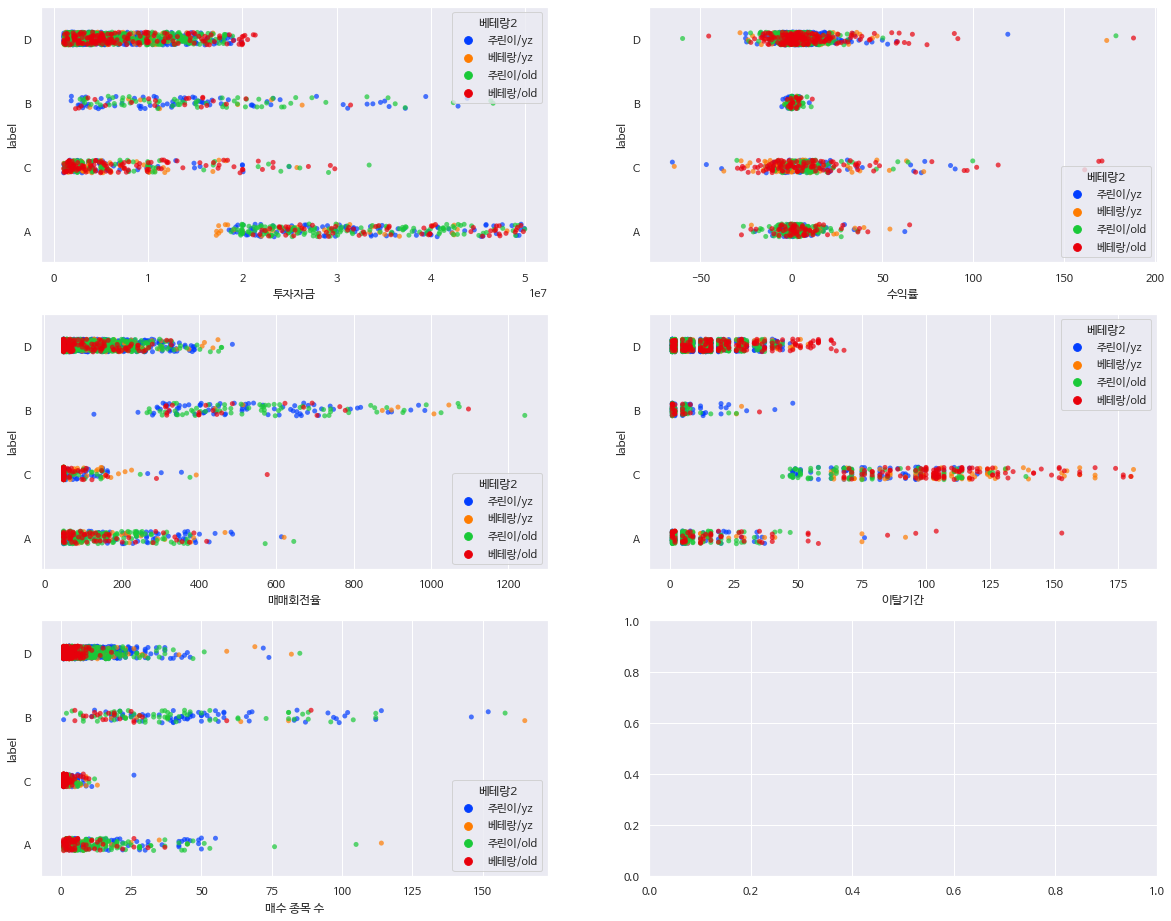

In [171]:
sns.set_style(style = 'darkgrid')
plt.rc('font', family='NanumBarunGothic') 
fig, ax= plt.subplots(figsize = (20,16), ncols = 2 , nrows = 3)
sns.stripplot(data = z, y = 'label', x= '투자자금', ax= ax[0][0], hue = '베테랑2', alpha = 0.7, palette= "bright")
sns.stripplot(data = z, y = 'label', x= '수익률', ax= ax[0][1], hue = '베테랑2', alpha = 0.7, palette= "bright")
sns.stripplot(data = z, y = 'label', x= '매매회전율', ax= ax[1][0], hue = '베테랑2', alpha = 0.7, palette= "bright")
sns.stripplot(data = z, y = 'label', x= '이탈기간', ax= ax[1][1], hue = '베테랑2', alpha = 0.7, palette= "bright")
sns.stripplot(data = z, y = 'label', x= '매수 종목 수', ax= ax[2][0], hue = '베테랑2', alpha = 0.7, palette= "bright")

In [88]:
z[z['베테랑2'] == '주린이/yz']['수익률'].mean()

4.312677754393772

In [89]:
z[z['베테랑2'] == '주린이/old']['수익률'].mean()

3.9197859896875475

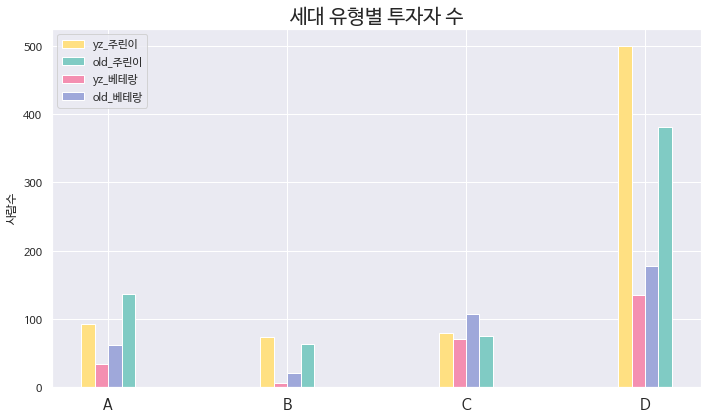

In [172]:
labels = ['A', 'B', 'C', 'D']
yz_new = z[z['베테랑2'] == '주린이/yz']['label'].value_counts().sort_index()
old_new = z[z['베테랑2'] == '주린이/old']['label'].value_counts().sort_index()
yz_old = z[z['베테랑2'] == '베테랑/yz']['label'].value_counts().sort_index()
old_old = z[z['베테랑2'] == '베테랑/old']['label'].value_counts().sort_index()

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize = (10,6))

rects1 = ax.bar(x - width*3/4, yz_new, width/2, label='yz_주린이', color = '#ffe082')
rects2 = ax.bar(x + width*3/4, old_new, width/2, label='old_주린이', color = '#80cbc4')
rects3 = ax.bar(x - width/4, yz_old, width/2, label='yz_베테랑', color = '#f48fb1')
rects4 = ax.bar(x + width/4, old_old, width/2, label='old_베테랑', color = '#9fa8da')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('사람수')
ax.set_title('세대 유형별 투자자 수', fontsize = 20)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize = 15)
ax.legend()


fig.tight_layout()

plt.show()

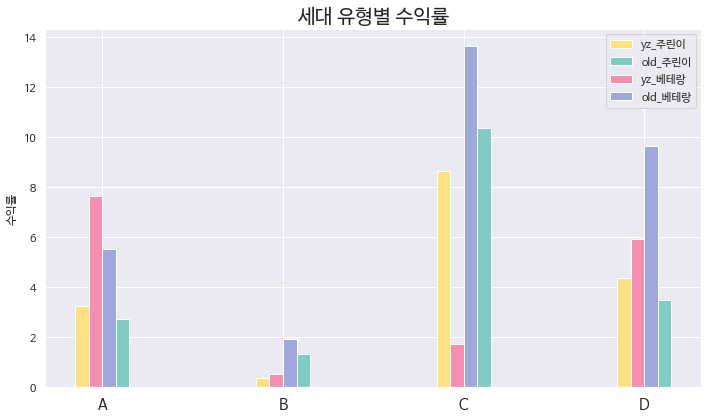

In [91]:
labels = ['A', 'B', 'C', 'D']
yz_new = [z[(z['베테랑2'] == '주린이/yz') & (z['label'] == 'A')]['수익률'].mean(),z[(z['베테랑2'] == '주린이/yz') & (z['label'] == 'B')]['수익률'].mean(),z[(z['베테랑2'] == '주린이/yz') & (z['label'] == 'C')]['수익률'].mean(),z[(z['베테랑2'] == '주린이/yz') & (z['label'] == 'D')]['수익률'].mean()]
old_new = [z[(z['베테랑2'] == '주린이/old') & (z['label'] == 'A')]['수익률'].mean(),z[(z['베테랑2'] == '주린이/old') & (z['label'] == 'B')]['수익률'].mean(),z[(z['베테랑2'] == '주린이/old') & (z['label'] == 'C')]['수익률'].mean(),z[(z['베테랑2'] == '주린이/old') & (z['label'] == 'D')]['수익률'].mean()]
yz_old = [z[(z['베테랑2'] == '베테랑/yz') & (z['label'] == 'A')]['수익률'].mean(),z[(z['베테랑2'] == '베테랑/yz') & (z['label'] == 'B')]['수익률'].mean(),z[(z['베테랑2'] == '베테랑/yz') & (z['label'] == 'C')]['수익률'].mean(),z[(z['베테랑2'] == '베테랑/yz') & (z['label'] == 'D')]['수익률'].mean()]
old_old = [z[(z['베테랑2'] == '베테랑/old') & (z['label'] == 'A')]['수익률'].mean(),z[(z['베테랑2'] == '베테랑/old') & (z['label'] == 'B')]['수익률'].mean(),z[(z['베테랑2'] == '베테랑/old') & (z['label'] == 'C')]['수익률'].mean(),z[(z['베테랑2'] == '베테랑/old') & (z['label'] == 'D')]['수익률'].mean()]

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize = (10,6))

rects1 = ax.bar(x - width*3/4, yz_new, width/2, label='yz_주린이', color = '#ffe082')
rects2 = ax.bar(x + width*3/4, old_new, width/2, label='old_주린이', color = '#80cbc4')
rects3 = ax.bar(x - width/4, yz_old, width/2, label='yz_베테랑', color = '#f48fb1')
rects4 = ax.bar(x + width/4, old_old, width/2, label='old_베테랑', color = '#9fa8da')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('수익률')
ax.set_title('세대 유형별 수익률', fontsize = 20)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize = 15)
ax.legend()


fig.tight_layout()

plt.show()

In [179]:
z.groupby(['label','세대2'], as_index = False)['고객번호'].count()

,label,세대2,고객번호
0,A,old,198
1,A,yz,126
2,B,old,85
3,B,yz,80
4,C,old,183
5,C,yz,150
6,D,old,558
7,D,yz,635


In [92]:
# 각각 성향에 따른 거래내역 분류
A_trd = real_all_fn.loc[real_all_fn['고객번호'].isin(list(z[z['label'] == 'A']['고객번호']))]
B_trd = real_all_fn.loc[real_all_fn['고객번호'].isin(list(z[z['label'] == 'B']['고객번호']))]
C_trd = real_all_fn.loc[real_all_fn['고객번호'].isin(list(z[z['label'] == 'C']['고객번호']))]
D_trd = real_all_fn.loc[real_all_fn['고객번호'].isin(list(z[z['label'] == 'D']['고객번호']))]

A_yz_trd = A_trd.loc[(real_all_fn['세대'] == 'y') | (real_all_fn['세대'] == 'z'), :]
B_yz_trd = B_trd.loc[(real_all_fn['세대'] == 'y') | (real_all_fn['세대'] == 'z'), :]
C_yz_trd = C_trd.loc[(real_all_fn['세대'] == 'y') | (real_all_fn['세대'] == 'z'), :]
D_yz_trd = D_trd.loc[(real_all_fn['세대'] == 'y') | (real_all_fn['세대'] == 'z'), :]
A_old_trd = A_trd.loc[(real_all_fn['세대'] == 'old'), :]
B_old_trd = B_trd.loc[(real_all_fn['세대'] == 'old'), :]
C_old_trd = C_trd.loc[(real_all_fn['세대'] == 'old'), :]
D_old_trd = D_trd.loc[(real_all_fn['세대'] == 'old'), :]

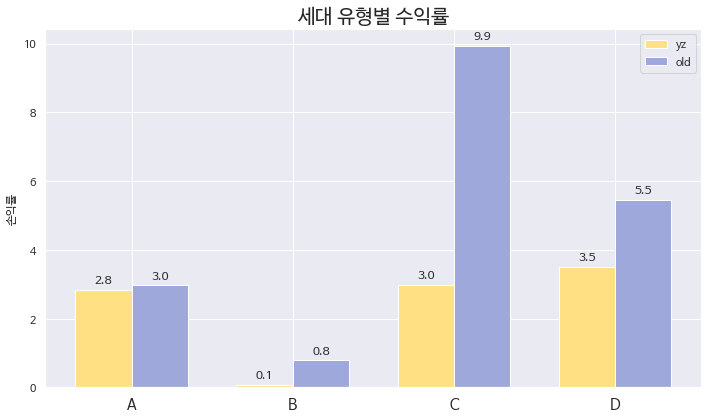

In [93]:
labels = ['A', 'B', 'C', 'D']
yz_means = [cluster_profit(A_yz_trd),cluster_profit(B_yz_trd),cluster_profit(C_yz_trd),cluster_profit(D_yz_trd)]
old_means = [cluster_profit(A_old_trd),cluster_profit(B_old_trd),cluster_profit(C_old_trd),cluster_profit(D_old_trd)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize = (10,6))

rects1 = ax.bar(x - width/2, yz_means, width, label='yz', color = '#ffe082')
rects2 = ax.bar(x + width/2, old_means, width, label='old', color = '#9fa8da')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('손익률')
ax.set_title('세대 유형별 수익률', fontsize = 20)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize = 15)
ax.legend()
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{0:.1f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

#### A의 경우, 높은 자금을 보유하였지만 수익률 3%에 그쳤다. 처음 프로젝트를 시작할 때, 운용 자금이 많으면 그만큼 수익률에도 영향이 있지 않을까 싶었는데 결국은 실력 싸움인거 같다.
#### B의 경우, 높은 매매회전율을 보였지만 안타깝게도 가장 하위 수익률을 기록하였다.
#### C의 경우, old그룹이 압도적으로 매우 높은 수익률을 보였는데 추가적인 종목 분석이 필요하다고 생각된다. 특히 yz세대와 old세대 간의 7% 차이가 어떤 종목에서 발생한 것인지 알아보고자 한다.
#### D의 경우, 나쁘지 않은 수익률을 보이지만 C와 마찬가지로 yz세대와 old세대간 2% 차이가 어디서 발생한 것인지 알아볼 필요가 있다. 

### 4.2 선호종목 분석
#### 두 가지 측면에서 분석
>* ㄱ. 단순 매수 여부(하늘색) : 해당 종목을 매수한 적이 한 번이라도 있으면 +1
>* ㄴ. 비용 가중치 점수(녹색) : 사람마다 특정 종목에 투자한 비중이 다르므로 각 종목별 매수에 쓴 비용을 정규화(MinMax) 작업 후 더해준 값(운용 투자자금의 편차를 줄여주기 위함)

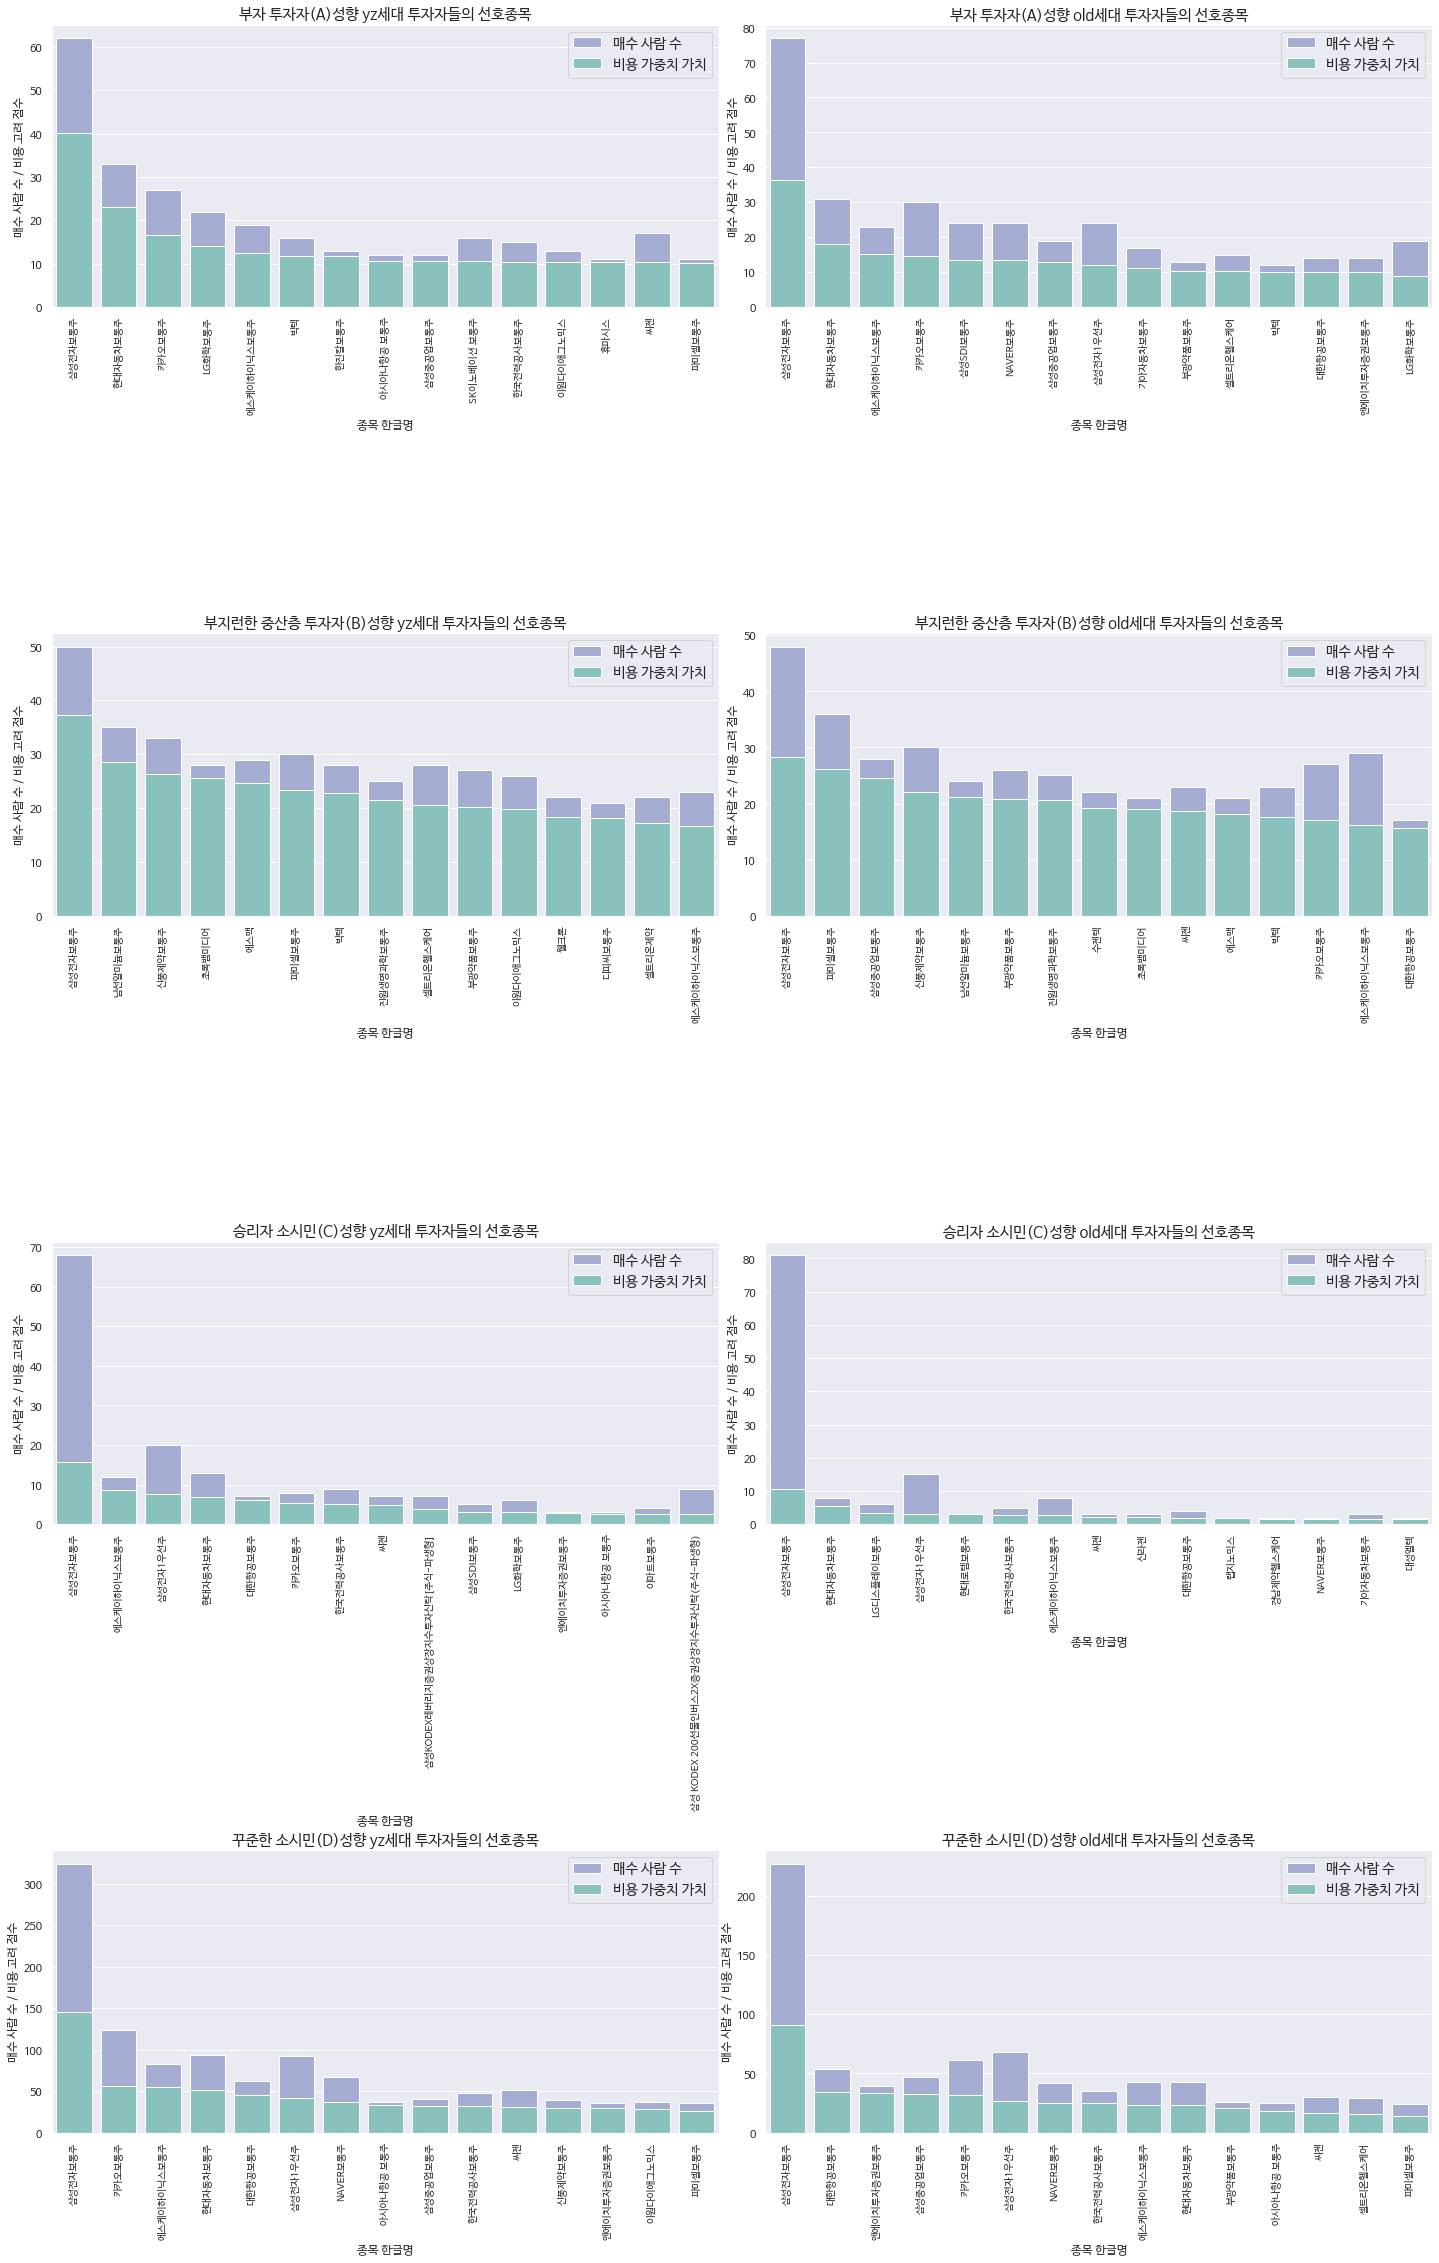

In [180]:
sns.set_style(style = 'darkgrid')
plt.rc('font', family='NanumBarunGothic') 
fig, ax = plt.subplots(figsize = (20,30) , nrows = 4, ncols = 2)
fig.tight_layout(h_pad = 25)
scale_plot_v2(A_yz_trd, MinMaxScaler(), '부자 투자자(A)성향 yz세대 투자자들의 선호종목',  ax[0][0])
scale_plot_v2(A_old_trd, MinMaxScaler(), '부자 투자자(A)성향 old세대 투자자들의 선호종목',ax[0][1])
scale_plot_v2(B_yz_trd, MinMaxScaler(), '부지런한 중산층 투자자(B)성향 yz세대 투자자들의 선호종목',  ax[1][0])
scale_plot_v2(B_old_trd, MinMaxScaler(), '부지런한 중산층 투자자(B)성향 old세대 투자자들의 선호종목',ax[1][1])
scale_plot_v2(C_yz_trd, MinMaxScaler(), '승리자 소시민(C)성향 yz세대 투자자들의 선호종목',  ax[2][0])
scale_plot_v2(C_old_trd, MinMaxScaler(), '승리자 소시민(C)성향 old세대 투자자들의 선호종목',ax[2][1])
scale_plot_v2(D_yz_trd, MinMaxScaler(), '꾸준한 소시민(D)성향 yz세대 투자자들의 선호종목',  ax[3][0])
scale_plot_v2(D_old_trd, MinMaxScaler(), '꾸준한 소시민(D)성향 old세대 투자자들의 선호종목',ax[3][1])

#### 주목할만한 부분으로는 수익률이 가장 높았던 C그룹의 양상이 다른 그룹들과 달랐다. 다른 그룹들도 [삼성전자보통주]가 1순위를 기록하였지만 C그룹의 경우 유독 삼전에 몰린 것을 확인할 수 있다. 이들의 수익률이 결국 삼전의 매수매도 시점에 있지 않을까 생각된다. 또한 유일하게 C의 yz세대 경우, 인버스, 레버리지 상품이 순위에 들었다. 반면 B의 경우 높은 매매회전율과 매수 종목 수를 보이는 그룹이었는데 그에 따라 종목간 차이가 크게 나지 않음을 확인할 수 있었다. 이들은 다양한 종목에 단타로 치고 빠지는 식의 투자를 하지 않았나 예상해본다. 

### 4.3 손익 분석
#### 두 가지 측면에서 분석
> * ㄱ. 매매비용 결산한 종목별 전체 손익을 계산하여 각 유형에 큰 영향을 준 종목들 비교
> * ㄴ. 같은 유형 중, 세대별로 비교하여 중복되지 않는 종목을 차별되는 종목으로 판단하고 비교분석
#### ㄱ. 매매비용 결산한 종목별 전체 손익을 계산하여 각 유형에 큰 영향을 준 종목들 비교

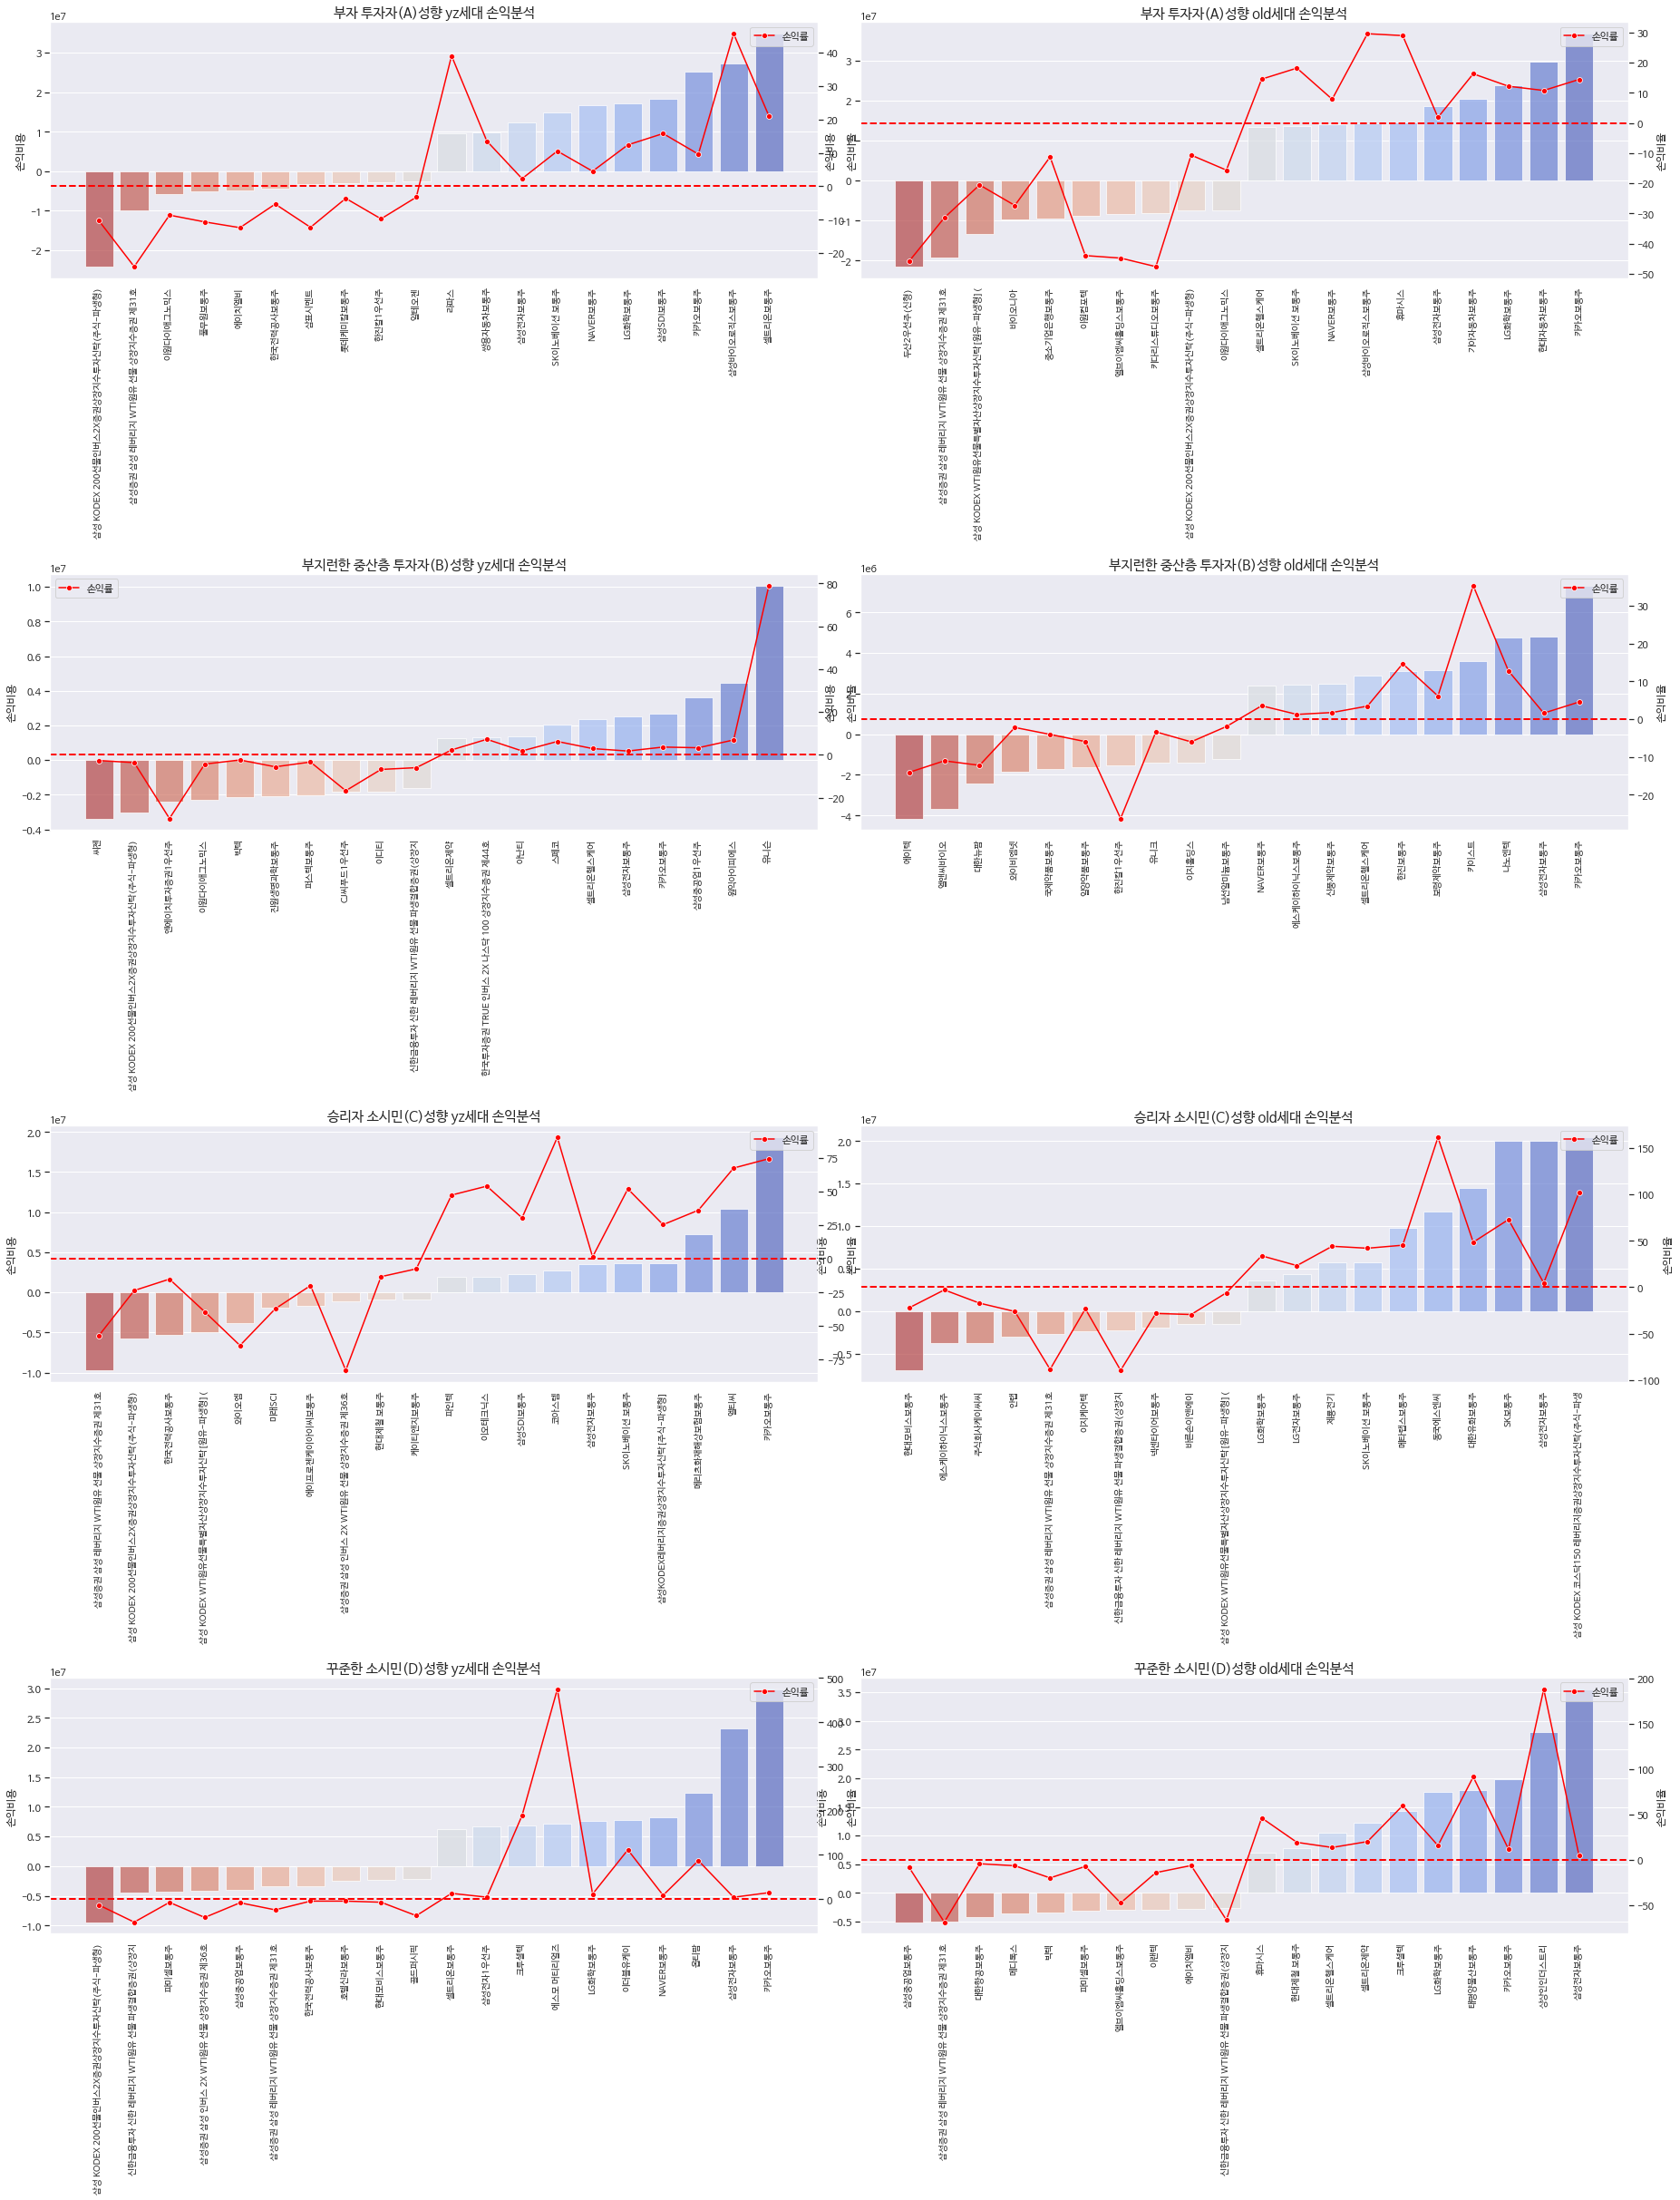

In [181]:
fig, ax= plt.subplots(figsize = (25,30), ncols =2, nrows = 4)
fig.tight_layout(h_pad = 25)
plot_sonic(A_yz_trd, '부자 투자자(A)성향 yz세대 손익분석', ax[0][0])
plot_sonic(A_old_trd, '부자 투자자(A)성향 old세대 손익분석', ax[0][1])
plot_sonic(B_yz_trd, '부지런한 중산층 투자자(B)성향 yz세대 손익분석', ax[1][0])
plot_sonic(B_old_trd, '부지런한 중산층 투자자(B)성향 old세대 손익분석', ax[1][1])
plot_sonic(C_yz_trd, '승리자 소시민(C)성향 yz세대 손익분석', ax[2][0])
plot_sonic(C_old_trd, '승리자 소시민(C)성향 old세대 손익분석', ax[2][1])
plot_sonic(D_yz_trd, '꾸준한 소시민(D)성향 yz세대 손익분석', ax[3][0])
plot_sonic(D_old_trd, '꾸준한 소시민(D)성향 old세대 손익분석', ax[3][1])

#### ㄴ. 세대별 중복되는 종목 제거하여 차별화되는 종목 발굴

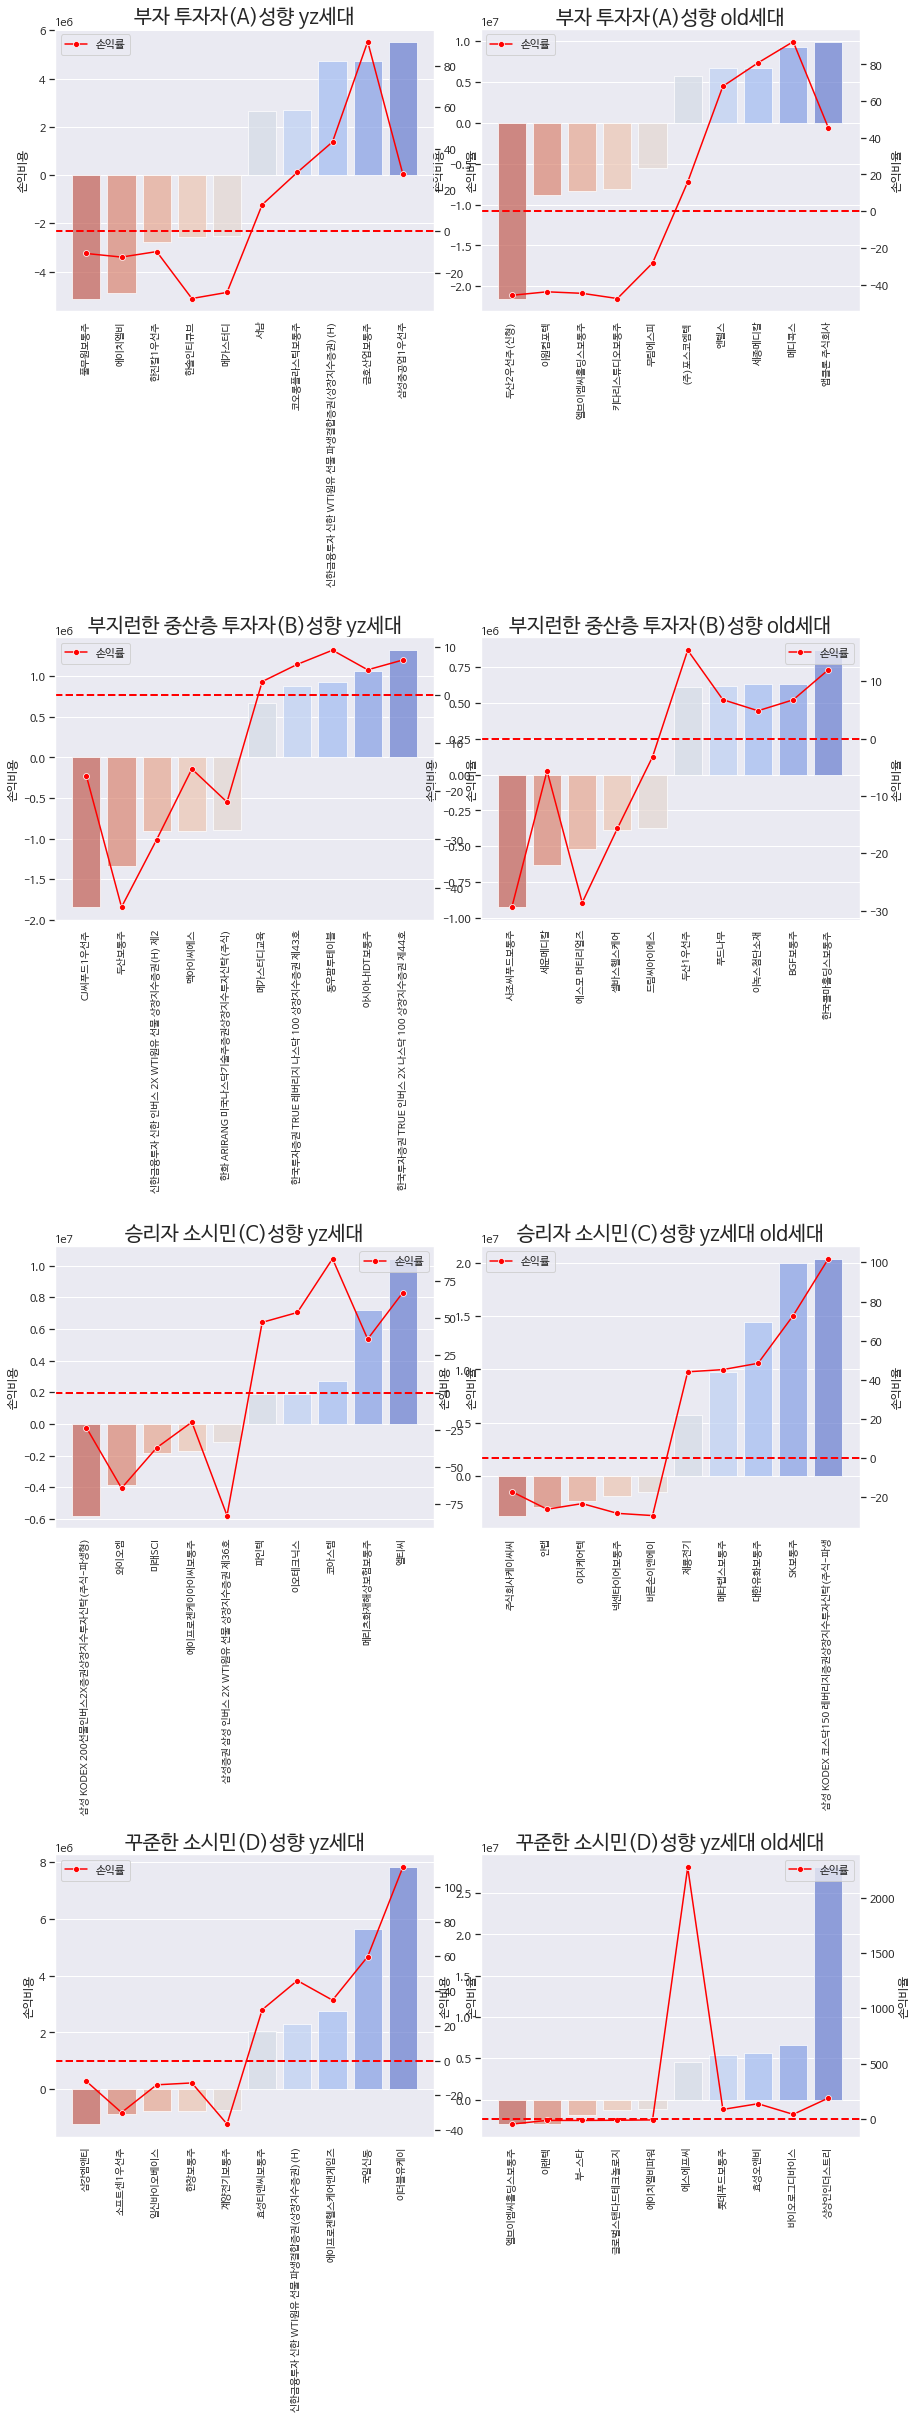

In [96]:
fig, ax= plt.subplots(figsize = (12,30), ncols = 2 , nrows= 4)
fig.tight_layout(h_pad = 25)
comp_plot(A_yz_trd, A_old_trd, '부자 투자자(A)성향 yz세대', '부자 투자자(A)성향 old세대', ax[0][0], ax[0][1])
comp_plot(B_yz_trd, B_old_trd, '부지런한 중산층 투자자(B)성향 yz세대', '부지런한 중산층 투자자(B)성향 old세대', ax[1][0], ax[1][1])
comp_plot(C_yz_trd, C_old_trd, '승리자 소시민(C)성향 yz세대', '승리자 소시민(C)성향 yz세대 old세대', ax[2][0], ax[2][1])
comp_plot(D_yz_trd, D_old_trd, '꾸준한 소시민(D)성향 yz세대', '꾸준한 소시민(D)성향 yz세대 old세대', ax[3][0], ax[3][1])

# 5. 결론
### 5.1 각 유형의 약점을 보완해줄 수 있는 상품, 아이디어 제안
### 5.2 마무리